In [1]:
# ==========================================
# ⚡ GPU + XLA acceleration (added at top)
# ==========================================
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"   # Enable XLA fusion
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"             # suppress TF INFO/WARN
os.environ["TF_CPP_MAX_VLOG_LEVEL"] = "0"            # suppress verbose C++ logs

import logging, absl.logging
import tensorflow as tf

# 🔧 Threading config MUST be set before TF runtime initializes
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

# Logging levels
tf.get_logger().setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)

# XLA JIT
tf.config.optimizer.set_jit(True)                    # Just-In-Time compile

# Enable full GPU memory and multi-GPU graph
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ {len(gpus)} GPU(s) active, memory growth enabled.")
else:
    print("ℹ️ CPU mode.")

tf.debugging.set_log_device_placement(False)



# =========================
# Cell 1 — Setup & Splits
# =========================
import os

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 2=warnings+errors, 3=errors only
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"

import json, random
import numpy as np
import h5py
import joblib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import logging
import absl.logging
tf.get_logger().setLevel('ERROR')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)



# --- Quiet TF a bit ---
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# # --- GPU: enable memory growth if present (safe no-op on CPU) ---
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     try:
#         for g in gpus:
#             tf.config.experimental.set_memory_growth(g, True)
#         print(f"✅ GPUs: {len(gpus)} | Memory growth enabled")
#     except Exception as e:
#         print("⚠️ GPU setup issue:", e)
# else:
#     print("ℹ️ No GPU detected (CPU mode)")

# --- Paths ---
DATA_DIR = os.getenv("PBROM_DATA_DIR", "PBROM data")  # change if your folder name differs
os.makedirs("models", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("scalers", exist_ok=True)
os.makedirs("ablation", exist_ok=True)
os.makedirs("figs", exist_ok=True)

# # --- ⭐️ MODIFIED: File lists are now grouped ⭐️ ---
# This is now the "single source of truth" for all files.
# Based on your request for granular, per-cell groups.


TRAIN_GROUPS = {
    "PBROM_Cells_2": [
        "PBROM_data_cell_32.mat",
    ]
}

VAL_GROUPS = {
    "PBROM_Cells_2_Val": [
        "PBROM_data_cell_33.mat",
    ]
}

TEST_GROUPS = {
    "PBROM_Cells_2_Test": [
        "PBROM_data_cell_35.mat",
    ]
}



# --- ⭐️ NEW: Auto-generate flat lists and lookup map ⭐️ ---
# (This code builds all the helper lists we need)

TRAIN_FILES = [f for files in TRAIN_GROUPS.values() for f in files]
VAL_FILES = [f for files in VAL_GROUPS.values() for f in files]
TEST_FILES = [f for files in TEST_GROUPS.values() for f in files]

# This is our critical "lookup map"
# It maps every single file to a group name, which we use to load the correct scaler
FILE_TO_GROUP_MAP = {}
all_groups = {**TRAIN_GROUPS, **VAL_GROUPS, **TEST_GROUPS}
for group, files in all_groups.items():
    for f in files:
        # We find the "base" name for the scaler (e.g., "PBROM_Cells_1")
        # This allows "PBROM_Cells_1_Val" to use the "PBROM_Cells_1" scaler
        base_group = group.split('_Val')[0].split('_Test')[0]
        FILE_TO_GROUP_MAP[f] = base_group

print(f"✅ File map generated: {len(FILE_TO_GROUP_MAP)} files mapped to base groups.")
print(f"  Example lookup: {TRAIN_FILES[0]} -> {FILE_TO_GROUP_MAP.get(TRAIN_FILES[0])}")
print(f"  Example lookup: {VAL_FILES[0]} -> {FILE_TO_GROUP_MAP.get(VAL_FILES[0])}")
print(f"  Example lookup: {TEST_FILES[0]} -> {FILE_TO_GROUP_MAP.get(TEST_FILES[0])}")
# -----------------------------------------------------------


# --- Helper: robust HDF5 .mat loader (squeezes to 1D/2D np arrays) ---
def _read_field(f, key, required=True):
    if key not in f:
        if required:
            raise KeyError(f"Missing key '{key}' in MAT file.")
        return None
    arr = np.array(f[key])
    # MATLAB often stores column vectors as (1, N) or (N, 1); squeeze safely
    return np.squeeze(arr)

def load_mat(file_name):
    """
    Loads a PBROM/NASA cell .mat file and returns a dict of numpy arrays:
      I_p, SOC_p, Time_s_p, Q_exp_p, Q_total_p, V_cum_p, Temp_cum_p,
      C_rate_profile, Bat_cap_profile, R_ch_profile, V_max_profile, V_min_profile,
      Cap_Nom, t_exp
    """
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Couldn't find: {path}")
    with h5py.File(path, "r") as f:
        data = {
            "I_p":                 _read_field(f, "I_p"),
            "SOC_p":               _read_field(f, "SOC_p"),
            "Time_s_p":            _read_field(f, "Time_s_p"),
            "Q_exp_p":             _read_field(f, "Q_exp_p"),
            "Q_total_p":           _read_field(f, "Q_total_p"),
            "V_cum_p":             _read_field(f, "V_cum_p"),
            "Temp_cum_p":          _read_field(f, "Temp_cum_p"),
            "C_rate_profile":      _read_field(f, "C_rate_profile"),
            "Bat_cap_profile":     _read_field(f, "Bat_cap_profile"),
            "R_ch_profile":        _read_field(f, "R_ch_profile"),
            "V_max_profile":       _read_field(f, "V_max_profile"),
            "V_min_profile":       _read_field(f, "V_min_profile"),
            "Cap_Nom":             _read_field(f, "Cap_Nom"),
            "t_exp":               _read_field(f, "t_exp"),
        }
    return data

# --- Quick sanity: print counts and peek sizes if files exist ---
def _peek(files, tag):
    ok = 0
    for fn in files:
        try:
            d = load_mat(fn)
            n = len(np.atleast_1d(d["Time_s_p"]))
            print(f"[{tag}] {fn}: N={n}")
            ok += 1
        except Exception as e:
            print(f"[{tag}] {fn}: ({e})")
    print(f"[{tag}] Found/loaded {ok}/{len(files)} files in '{DATA_DIR}'")

print("\nVerifying file availability (optional):")
# _peek now uses the new auto-generated flat lists
_peek(TRAIN_FILES, "TRAIN")
_peek(VAL_FILES,   "VAL")
_peek(TEST_FILES,  "TEST")

# =========================
# ADD TO END OF CELL 1
# =========================

# Get all unique "base" group names from the file map
# This ensures all groups (train, val, test) are included
ALL_BASE_GROUPS = sorted(list(set(FILE_TO_GROUP_MAP.values())))

# Create the ID mapping
GROUP_TO_ID_MAP = {group_name: i for i, group_name in enumerate(ALL_BASE_GROUPS)}
NUM_GROUPS = len(ALL_BASE_GROUPS)

print(f"\n✅ Group ID map generated ({NUM_GROUPS} total groups):")
for group_name, idx in GROUP_TO_ID_MAP.items():
    print(f"  {idx}: {group_name}")

# This map will now be available to all other cells

print("\n✅ Cell 1 ready: imports, seeds, GPU setup, dirs, splits, loader.")

✅ 1 GPU(s) active, memory growth enabled.
✅ File map generated: 3 files mapped to base groups.
  Example lookup: PBROM_data_cell_32.mat -> PBROM_Cells_2
  Example lookup: PBROM_data_cell_33.mat -> PBROM_Cells_2
  Example lookup: PBROM_data_cell_35.mat -> PBROM_Cells_2

Verifying file availability (optional):
[TRAIN] PBROM_data_cell_32.mat: N=64783
[TRAIN] Found/loaded 1/1 files in 'PBROM data'
[VAL] PBROM_data_cell_33.mat: N=64331
[VAL] Found/loaded 1/1 files in 'PBROM data'
[TEST] PBROM_data_cell_35.mat: N=64183
[TEST] Found/loaded 1/1 files in 'PBROM data'

✅ Group ID map generated (1 total groups):
  0: PBROM_Cells_2

✅ Cell 1 ready: imports, seeds, GPU setup, dirs, splits, loader.


In [2]:
# ==========================================================
# Cell 2 — Pass-0 (v2 - Automatic Clipping Scaler)
# ==========================================================
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib  # <-- ⭐️ FIX: Corrected typo here

# ---- Targets scaling constant (keep consistent everywhere) ----
SCALE_DELTA = 1e5
# ---- Normalization constants ----
T_MIN = 10.0  # Common-sense min operating temp (C)
T_MAX = 50.0  # Common-sense max operating temp (C)

# ---- ⭐️ REPLACED: Robust PercentileScaler with Automatic Clipping ⭐️ ----
class PercentileScaler:
    """
    (Upgraded)
    Scales data by dividing by the 'p_scale' percentile.
    Automatically clips the output at the 'p_clip' percentile
    to prevent extreme outliers from poisoning the optimizer.
    """
    def __init__(self, p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20):
        self.p_scale = p_scale
        self.p_clip = p_clip
        self.eps = eps
        self.min_pos = min_pos
        self.scale_ = 1.0
        self.clip_limit_ = 1e9 # Default to a huge number

    def fit(self, x):
        x = np.asarray(x).reshape(-1)
        x_pos = x[x > 0] # Only fit on positive values

        if x_pos.size < self.min_pos:
            # Not enough data, use fallback
            if x.size > 0:
                p_scale_val = np.percentile(x, max(self.p_scale, 99))
                p_clip_val = np.percentile(x, max(self.p_clip, 99.9))
            else:
                p_scale_val = 1.0
                p_clip_val = 1.0
        else:
            # We have enough positive data to get good percentiles
            p_scale_val = np.percentile(x_pos, self.p_scale)
            p_clip_val = np.percentile(x_pos, self.p_clip)

        self.scale_ = max(float(p_scale_val), self.eps)
        
        # --- This is the new part ---
        # Calculate the scaled clip limit
        # e.g., if p_clip (3.55) / p_scale (2.39) = 1.48
        self.clip_limit_ = max(float(p_clip_val) / self.scale_, 1.0) # Must be at least 1.0
        # ---

    def transform(self, x):
        x_scaled = np.asarray(x).reshape(-1, 1) / self.scale_
        
        # --- This is the new part ---
        # Automatically apply the per-group clipping
        x_clipped = np.clip(x_scaled, 0.0, self.clip_limit_)
        # ---
        return x_clipped

    def inverse_transform(self, x):
        # Inverse transform should not be clipped
        return np.asarray(x).reshape(-1, 1) * self.scale_


# ---- Utilities for Pass-0 ----
# (No changes needed in _grab_scalar, compute_global_time_percentiles,
# or collect_positive_deltas_scaled)

def _grab_scalar(x, default=0.0):
    arr = np.asarray(x).reshape(-1)
    return float(arr[0]) if arr.size else default

def compute_global_time_percentiles(train_files):
    elapsed_pool = []
    dt_pool = []
    for fn in train_files:
        d = load_mat(fn)
        t = d["Time_s_p"].astype(np.float64).flatten()
        if t.size == 0:
            continue
        elapsed = t - t[0]
        dt = np.diff(t, prepend=t[0])
        elapsed_pool.append(elapsed)
        if dt.size > 1:
            dt_pool.append(dt[1:])  # skip the very first zero
    elapsed_all = np.concatenate(elapsed_pool) if elapsed_pool else np.array([1.0])
    dt_all = np.concatenate(dt_pool) if dt_pool else np.array([1.0])
    p95_t = float(np.percentile(elapsed_all, 95))
    p95_dt = float(np.percentile(dt_all, 95))
    return p95_t, p95_dt


def sample_dynamic_rows_for_scaler(train_files, p95_t, p95_dt,
                                    target_rows_total=2_000_000, include_winpos=True,
                                    window_size_for_winpos=100):
    per_file_target = max(50_000, target_rows_total // max(1, len(train_files)))
    rows = []
    for fn in train_files:
        d = load_mat(fn)
        SOC = np.atleast_1d(d["SOC_p"]).astype(np.float64).flatten()
        V   = np.atleast_1d(d["V_cum_p"]).astype(np.float64).flatten()
        T   = np.atleast_1d(d["Temp_cum_p"]).astype(np.float64).flatten()
        t   = np.atleast_1d(d["Time_s_p"]).astype(np.float64).flatten()
        # --- ⭐️ MODIFICATION: Load C-Rate ---
        Cr = np.atleast_1d(d["C_rate_profile"]).astype(np.float64).flatten()

        V_max = _grab_scalar(d["V_max_profile"], 4.2)
        V_min = _grab_scalar(d["V_min_profile"], 2.5)

        if t.size == 0: continue
        elapsed = t - t[0]
        dt = np.diff(t, prepend=t[0])
        t_abs_norm = np.clip(elapsed / max(p95_t, 1e-12), 0.0, 4.0)
        dt_norm    = np.clip(dt      / max(p95_dt, 1e-12), 0.0, 4.0)
        V_norm = np.clip((V - V_min) / max(V_max - V_min, 1e-6), -1.0, 2.0)
        T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)

        # --- ⭐️ MODIFICATION: Add Cr to min size check ---
        N = min(SOC.size, V_norm.size, T_norm.size, t_abs_norm.size, dt_norm.size, Cr.size)
        if N <= 0: continue

        if N <= per_file_target: idx = np.arange(N)
        else: idx = np.linspace(0, N - 1, per_file_target).astype(int)

        if include_winpos:
            wp_vec = np.linspace(0, 1, window_size_for_winpos)
            win_pos_approx = np.resize(wp_vec, idx.size)
            # --- ⭐️ MODIFICATION: Add Cr (6th feature) to stack ---
            dyn = np.stack([ SOC[idx], V_norm[idx], T_norm[idx], t_abs_norm[idx], dt_norm[idx], Cr[idx], win_pos_approx ], axis=1)
        else:
            # --- ⭐️ MODIFICATION: Add Cr (6th feature) to stack ---
            dyn = np.stack([ SOC[idx], V_norm[idx], T_norm[idx], t_abs_norm[idx], dt_norm[idx], Cr[idx] ], axis=1)
        rows.append(dyn)

    # --- ⭐️ MODIFICATION: Update fallback shape to 7 columns ---
    if not rows: return np.zeros((10, 7), dtype=np.float64)
    return np.vstack(rows)


def collect_positive_deltas_scaled(train_files):
    """Collect positive (ΔQ_exp_norm, ΔQ_PB_norm) * SCALE_DELTA across a list of files."""
    buf = []
    for fn in train_files:
        d = load_mat(fn)
        # --- Q values are ALREADY NORMALIZED ---
        Qe_norm = np.atleast_1d(d["Q_exp_p"]).astype(np.float64).flatten()
        Qp_norm = np.atleast_1d(d["Q_total_p"]).astype(np.float64).flatten()

        if Qe_norm.size < 2 or Qp_norm.size < 2:
            continue

        dq_e_norm = np.maximum(Qe_norm[1:] - Qe_norm[:-1], 0.0)
        dq_p_norm = np.maximum(Qp_norm[1:] - Qp_norm[:-1], 0.0)
        
        dq_e = dq_e_norm * SCALE_DELTA
        dq_p = dq_p_norm * SCALE_DELTA

        if dq_e.size: buf.append(dq_e)
        if dq_p.size: buf.append(dq_p)

    if not buf: return np.array([1.0])
    return np.concatenate(buf)

# ---- Execute Pass-0 ----
print("\n[Pass-0] Computing global time percentiles ...")
p95_t, p95_dt = compute_global_time_percentiles(TRAIN_FILES)
print(f"  p95_t  = {p95_t:.6e}")
print(f"  p95_dt = {p95_dt:.6e}")

print("\n[Pass-0] Sampling dynamic rows for *global* feature scaler fit ...")
# THIS IS THE CORRECT LINE
dyn_rows = sample_dynamic_rows_for_scaler(TRAIN_FILES, p95_t, p95_dt)
print(f"  Pooled dynamic sample shape: {dyn_rows.shape}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(dyn_rows)
joblib.dump(feature_scaler, os.path.join("scalers", "feature_scaler.pkl"))
print("  ✓ Saved *global* feature scaler → scalers/feature_scaler.pkl")


# --- ⭐️ MODIFIED: Fit one auto-clipping scaler PER GROUP ⭐️ ---
print("\n[Pass-0] Fitting *per-group* delta PercentileScaler (auto-clipping)...")
for group_name, file_list in TRAIN_GROUPS.items():
    if not file_list: continue
    
    print(f"  Fitting for group: {group_name} ({len(file_list)} files)")
    dq_group = collect_positive_deltas_scaled(file_list)
    
    # Use the new scaler class
    delta_scaler_group = PercentileScaler(p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20)
    delta_scaler_group.fit(dq_group)
    
    scaler_filename = f"delta_scaler_{group_name}.pkl"
    scaler_path = os.path.join("scalers", scaler_filename)
    joblib.dump(delta_scaler_group, scaler_path)
    # ⭐️ (Added clip_limit_ to the print statement) ⭐️
    print(f"  ✓ Saved '{group_name}' scaler (scale_={delta_scaler_group.scale_:.4e}, clip_at_scaled_val={delta_scaler_group.clip_limit_:.4f}) → {scaler_path}")
# --- END MODIFICATION ---


# (Static scaler is unchanged)
def collect_static_rows(train_files):
    rows = []
    for fn in train_files:
        d = load_mat(fn)
        rows.append([ _grab_scalar(d["Bat_cap_profile"]), _grab_scalar(d["R_ch_profile"]), _grab_scalar(d["V_max_profile"]), _grab_scalar(d["V_min_profile"]) ])
    return np.array(rows, dtype=np.float64) if rows else np.zeros((1,4), dtype=np.float64)

print("\n[Pass-0] Fitting *global* static scaler (StandardScaler) ...")
static_rows = collect_static_rows(TRAIN_FILES)
static_scaler = StandardScaler()
static_scaler.fit(static_rows)
joblib.dump(static_scaler, os.path.join("scalers", "static_scaler.pkl"))
print("  ✓ Saved *global* static scaler → scalers/static_scaler.pkl")
print(f"  means = {static_scaler.mean_}, scale = {static_scaler.scale_}")

time_stats = {"p95_t": p95_t, "p95_dt": p95_dt}
with open(os.path.join("scalers", "time_stats.json"), "w") as f: json.dump(time_stats, f, indent=2)
print("  ✓ Saved time stats → scalers/time_stats.json")

print("\n[Pass-0] Diagnostics")
mins = dyn_rows.min(axis=0); maxs = dyn_rows.max(axis=0)
# --- ⭐️ MODIFICATION: Add "C_rate" to colnames ---
colnames = ["SOC", "V_norm", "T_norm", "t_abs_norm", "dt_norm", "C_rate", "win_pos"]
for i, name in enumerate(colnames): print(f"  {name:<11} min={mins[i]:.4g} max={maxs[i]:.4g}")

print("\n[Pass-0] Extracting raw scaler parameters for high-speed pipeline...")
# (This part is unchanged, but we'll add the clip limit to the npz)
fs = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
ss = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
scaler_params = {
    "feature_min": fs.min_,
    "feature_scale": fs.scale_,
    "static_mean": ss.mean_,
    "static_scale": ss.scale_,
}
for group_name in TRAIN_GROUPS.keys():
    scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
    if os.path.exists(scaler_path):
        ds = joblib.load(scaler_path)
        scaler_params[f"delta_scale_{group_name}"] = ds.scale_
        scaler_params[f"delta_clip_{group_name}"] = ds.clip_limit_ # ⭐️ NEW

scaler_npz_path = os.path.join("scalers", "scaler_params.npz")
np.savez_compressed(scaler_npz_path, **scaler_params)
print(f"✅ Raw scaler params (incl. clip limits) saved to → {scaler_npz_path}")
print("✅ Cell 2 complete.")


[Pass-0] Computing global time percentiles ...
  p95_t  = 1.188798e+07
  p95_dt = 2.000160e+02

[Pass-0] Sampling dynamic rows for *global* feature scaler fit ...
  Pooled dynamic sample shape: (64783, 7)
  ✓ Saved *global* feature scaler → scalers/feature_scaler.pkl

[Pass-0] Fitting *per-group* delta PercentileScaler (auto-clipping)...
  Fitting for group: PBROM_Cells_2 (1 files)
  ✓ Saved 'PBROM_Cells_2' scaler (scale_=3.4433e-01, clip_at_scaled_val=2.6396) → scalers/delta_scaler_PBROM_Cells_2.pkl

[Pass-0] Fitting *global* static scaler (StandardScaler) ...
  ✓ Saved *global* static scaler → scalers/static_scaler.pkl
  means = [0.022 1.3   4.1   3.   ], scale = [1. 1. 1. 1.]
  ✓ Saved time stats → scalers/time_stats.json

[Pass-0] Diagnostics
  SOC         min=0 max=0.994
  V_norm      min=-1 max=1.002
  T_norm      min=2 max=2
  t_abs_norm  min=0 max=1.099
  dt_norm     min=0 max=4
  C_rate      min=-4.319 max=5.183
  win_pos     min=0 max=1

[Pass-0] Extracting raw scaler parame

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


# ======================================
# Cell 3 — Main Hyperparameters (central)
# ======================================

# --- Windowing / dataset ---
WINDOW_SIZE = 10    # using 25-step window
STRIDE      = 1
BATCH_SIZE  = 1024   # (legacy; training actually uses BATCH_PER_DEVICE)

# --- ⭐️ MODIFIED: Simplified Architecture ---
EMBED_DIM       = 96    # Reduced from 64
NUM_HEADS       = 4
FF_DIM          = 64    # Reduced from 128
NUM_LAYERS      = 5     # Reduced from 2
SOFTPLUS_BETA   = 1.0
GROUP_EMBED_DIM = 8

# --- Regularization (Keep these) ---
DROPOUT         = 0.20
L2_REG          = 5e-4
GAUSSIAN_NOISE_STDDEV = 0.001

# --- Training / optimization ---
BATCH_PER_DEVICE = 1024  # effective batch size per GPU
EPOCHS           = 50   # you rarely need 50 with early stopping
LR               = 1.22e-8 # same stable LR that worked well for you
CLIPNORM         = 1.0
AMSGRAD          = True

# --- Loss weights ---
LAMBDA_DATA = 1.0
LAMBDA_PHYS = 0.4045
LAMBDA_ZERO = 0.0
HUBER_DELTA = 1.0 

# --- Scheduler / early stopping ---
VAL_FREQ            = 2   # validate more often to catch best epoch
EARLY_STOP_PATIENCE = 5   # 5×2=10 epochs of no improvement allowed
LR_PATIENCE         = 3
LR_FACTOR           = 0.5
LR_MIN              = 1e-6

# --- Constants ---
SCALE_DELTA = 1e5

print("✅ Hyperparameters registered.")
print(f"✅ ARCHITECTURE: {NUM_LAYERS} Layers, {EMBED_DIM} Embed Dim")
print(f"✅ REGULARIZATION: DROPOUT={DROPOUT}, L2_REG={L2_REG}, NOISE_STDDEV={GAUSSIAN_NOISE_STDDEV}")

✅ Hyperparameters registered.
✅ ARCHITECTURE: 5 Layers, 96 Embed Dim
✅ REGULARIZATION: DROPOUT=0.2, L2_REG=0.0005, NOISE_STDDEV=0.001


In [4]:
#!/usr/bin/env python
# coding: utf-8

# In[4]:


# ==========================================================
# Cell 4 — Model Builder (v7 - "Input Modulation" + L2 Reg + Noise)
# (Single-group variant: static features & group ID are ignored,
#  but inputs are kept for full compatibility with the pipeline.)
# ==========================================================
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Concatenate, TimeDistributed, Embedding, Lambda,
    Flatten, GaussianNoise
)
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

# (transformer_encoder_prenorm is unchanged from before)
def transformer_encoder_prenorm(x, head_size, num_heads, ff_dim, dropout, l2_reg):
    x_ln1 = LayerNormalization(epsilon=1e-6)(x)
    attn  = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x_ln1, x_ln1)
    attn  = Dropout(dropout)(attn)
    x     = Add()([x, attn])
    x_ln2 = LayerNormalization(epsilon=1e-6)(x)
    ff    = Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x_ln2)
    ff    = Dropout(dropout)(ff)
    ff    = Dense(x.shape[-1], kernel_regularizer=regularizers.l2(l2_reg))(ff)
    x     = Add()([x, ff])
    return x

# (SharedPositionalEncoding is unchanged)
class SharedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, window_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.window_size = int(window_size)
        self.embedding_dim = int(embedding_dim)
        self.embedding_layer = Embedding(
            input_dim=self.window_size,
            output_dim=self.embedding_dim,
            name="shared_pos_embedding"
        )

    def call(self, x):
        T = tf.shape(x)[1]
        positions = tf.range(start=0, limit=T, delta=1)
        pos_enc = self.embedding_layer(positions)
        pos_enc = tf.expand_dims(pos_enc, axis=0)
        pos_enc = tf.tile(pos_enc, [tf.shape(x)[0], 1, 1])
        return x + pos_enc

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "window_size": self.window_size,
            "embedding_dim": self.embedding_dim
        })
        return cfg

# ---- Model builder (v7, single-group variant) ----
def build_pitm_model(
    window_size,
    num_groups,                       # kept for API compatibility
    group_embed_dim=GROUP_EMBED_DIM,  # kept for API compatibility
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    l2_reg=L2_REG,
    noise_stddev=GAUSSIAN_NOISE_STDDEV
):
    """
    Physics-Informed Transformer Model (PITM) for ΔQ.

    Single-group variant:
    - Still accepts three inputs: dyn_in, static_in, group_id_in
      to match the existing training / testing / random-search pipeline.
    - Internally, the model now *ignores* static_in and group_id_in,
      so behavior is driven purely by dynamic features.
    """
    head_size = max(1, embed_dim // num_heads)

    # ----- 1. Define Inputs (3 total, unchanged signature) -----
    dyn_in      = Input(shape=(window_size, 7), name="dyn_in")
    static_in   = Input(shape=(4,),           name="static_in")
    group_id_in = Input(shape=(1,),           name="group_id_in", dtype="int32")

    # ----- 2. Data augmentation on dynamic input (unchanged) -----
    dyn_noised = GaussianNoise(noise_stddev, name="dyn_gaussian_noise")(dyn_in)

    # ----- 3. Ignore static and group ID in the computation -----
    # We keep static_in and group_id_in as inputs so that all upstream
    # code (build_training_arrays, stream_windows_from_files, predict_cell,
    # random search) can remain exactly the same.
    #
    # For the forward path, we simply use dyn_noised as-is.
    dyn_combined = dyn_noised  # no static concatenation anymore

    # ----- 4. Physics projection on dynamic-only features -----
    dyn_proj = TimeDistributed(
        Dense(
            embed_dim,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_reg)
        ),
        name="dyn_physics_projection"
    )(dyn_combined)

    # We still instantiate the group embedding layer for compatibility,
    # but we DO NOT add it to dyn_proj (i.e., no modulation).
    group_embed = Embedding(
        input_dim=num_groups,
        output_dim=embed_dim,
        embeddings_regularizer=regularizers.l2(l2_reg),
        name="group_embedding"
    )(group_id_in)
    # Old behaviour (multi-group modulation) was:
    #   dyn_modulated = Add(name="dyn_modulation")([dyn_proj, group_embed])
    # For single-group use, we now ignore group_embed:
    dyn_modulated = dyn_proj

    # ----- 5. Shared Transformer body (unchanged) -----
    shared_pos = SharedPositionalEncoding(window_size, embed_dim, name="shared_pos_enc")
    x = shared_pos(dyn_modulated)

    for _ in range(num_layers):
        x = transformer_encoder_prenorm(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            l2_reg=l2_reg
        )

    take_last = Lambda(lambda t: t[:, -1, :], name="take_last_token")
    x_last = take_last(x)

    # ----- 6. Output head (unchanged) -----
    fused = x_last
    fused_head = Dense(
        64,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused)
    fused_head = Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused_head)

    raw = Dense(
        1,
        name="raw_pre_softplus",
        bias_initializer=initializers.Constant(0.0),
        kernel_regularizer=regularizers.l2(l2_reg),
    )(fused_head)

    # --- 7. Final Activation (unchanged) ---
    def softplus32(z, beta=1.0):
        z32 = tf.cast(z, tf.float32)
        out32 = tf.nn.softplus(beta * z32) / beta
        return tf.cast(out32, z.dtype)

    delta_hat = Lambda(
        lambda z: softplus32(z, beta=SOFTPLUS_BETA),
        name="delta_hat"
    )(raw)

    model = Model(
        inputs=[dyn_in, static_in, group_id_in],
        outputs=delta_hat,
        name="PITM_DeltaTransformer_v7_Modulated_SingleGroup"
    )
    return model

# (Loss function is unchanged)
def pitm_delta_loss(lambda_data=1.0, lambda_phys=1.0, lambda_zero=0.0, huber_delta=1.5):
    def huber(e, delta):
        a = tf.abs(e)
        return tf.where(
            a <= delta,
            0.5 * tf.square(e),
            delta * (a - 0.5 * delta)
        )

    def _loss(y_true, y_pred):
        dq_exp = y_true[:, 0:1]
        dq_pb  = y_true[:, 1:2]
        dq_hat = y_pred

        pos_mask  = tf.cast(tf.logical_or(dq_exp > 0.0, dq_pb > 0.0), tf.float32)
        zero_mask = 1.0 - pos_mask

        l_data = tf.reduce_mean(huber(dq_exp - dq_hat, huber_delta))
        l_phys = tf.reduce_mean(huber(dq_pb  - dq_hat, huber_delta))
        l_zero = tf.reduce_mean(zero_mask * dq_hat)

        return lambda_data*l_data + lambda_phys*l_phys + lambda_zero*l_zero

    return _loss

# ---- Build model to check summary ----
print("Building model with v7 'Input Modulation' architecture (single-group variant):")
model = build_pitm_model(
    window_size=WINDOW_SIZE,
    num_groups=NUM_GROUPS,  # From Cell 1 (still passed, but not used for modulation)
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)
model.summary(line_length=120)
print("\n✅ Cell 4 ready: v7 'Modulated' single-group model built (uncompiled).")


Building model with v7 'Input Modulation' architecture (single-group variant):
Model: "PITM_DeltaTransformer_v7_Modulated_SingleGroup"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 dyn_in (InputLayer)                   [(None, 10, 7)]            0             []                                      
                                                                                                                        
 dyn_gaussian_noise (GaussianNoise)    (None, 10, 7)              0             ['dyn_in[0][0]']                        
                                                                                                                        
 dyn_physics_projection (TimeDistribut  (None, 10, 96)            768           ['dyn_gaussian_noise[0][0]']            
 ed)              

In [5]:
#!/usr/bin/env python
# coding: utf-8

# In[5]:


# ===============================================
# Cell 4.5 — Pass 1.5 as a reusable function
# Pre-process all training data (v3.1 - SAMPLE WEIGHTING)
# ===============================================
import numpy as np
import joblib
from tqdm import tqdm
import random

print("--- ⚙️ Cell 4.5 ready: use build_training_arrays(window_size, stride) to create in-memory training data ---")

def build_training_arrays(window_size, stride):
    """
    Build the in-memory, unbalanced training arrays with sample weights
    for a given window_size and stride.
    
    After calling this, the following globals are created:
        X_train_dyn, X_train_st, X_train_gid, y_train, train_sample_weights
    """
    global X_train_dyn, X_train_st, X_train_gid, y_train, train_sample_weights

    print(f"\n--- ⚙️ Pass 1.5: Building training arrays (window_size={window_size}, stride={stride}) ---")
    print("This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.")

    # --- Local helpers (same as before) ---
    def _grab_scalar(x, default=0.0):
        arr = np.asarray(x).reshape(-1)
        return float(arr[0]) if arr.size else default

    def _read_field(f, key, required=True):
        if key not in f:
            if required: 
                raise KeyError(f"Missing key '{key}' in MAT file.")
            return None
        arr = np.array(f[key])
        return np.squeeze(arr)

    def load_mat_local(file_name):
        path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Couldn't find: {path}")
        with h5py.File(path, "r") as f:
            data = {
                "I_p":              _read_field(f, "I_p"),
                "SOC_p":            _read_field(f, "SOC_p"),
                "Time_s_p":         _read_field(f, "Time_s_p"),
                "Q_exp_p":          _read_field(f, "Q_exp_p"),
                "Q_total_p":        _read_field(f, "Q_total_p"),
                "V_cum_p":          _read_field(f, "V_cum_p"),
                "Temp_cum_p":       _read_field(f, "Temp_cum_p"),
                "C_rate_profile":   _read_field(f, "C_rate_profile"),
                "Bat_cap_profile":  _read_field(f, "Bat_cap_profile"),
                "R_ch_profile":     _read_field(f, "R_ch_profile"),
                "V_max_profile":    _read_field(f, "V_max_profile"),
                "V_min_profile":    _read_field(f, "V_min_profile"),
                "Cap_Nom":          _read_field(f, "Cap_Nom"),
                "t_exp":            _read_field(f, "t_exp"),
            }
        return data

    def compute_global_time_percentiles_local(train_files):
        elapsed_pool = []
        dt_pool = []
        for fn in train_files:
            d = load_mat_local(fn)
            t = d["Time_s_p"].astype(np.float64).flatten()
            if t.size == 0: 
                continue
            elapsed = t - t[0]
            dt = np.diff(t, prepend=t[0])
            elapsed_pool.append(elapsed)
            if dt.size > 1: 
                dt_pool.append(dt[1:])
        elapsed_all = np.concatenate(elapsed_pool) if elapsed_pool else np.array([1.0])
        dt_all = np.concatenate(dt_pool) if dt_pool else np.array([1.0])
        p95_t = float(np.percentile(elapsed_all, 95))
        p95_dt = float(np.percentile(dt_all, 95))
        return p95_t, p95_dt

    def _make_time_channels_np(Time_s, p95_t_in, p95_dt_in):
        t = np.asarray(Time_s, np.float64).flatten()
        elapsed = t - t[0]
        dt = np.diff(t, prepend=t[0])
        t_abs_norm = np.clip(elapsed / max(p95_t_in,  1e-12), 0.0, 4.0)
        dt_norm    = np.clip(dt      / max(p95_dt_in, 1e-12), 0.0, 4.0)
        return t_abs_norm.astype(np.float64), dt_norm.astype(np.float64)

    def _positive_deltas_scaled_np(Q_norm, scale_delta_in):
        Q_norm = np.asarray(Q_norm, np.float64).flatten()
        if Q_norm.size < 2: 
            return np.zeros(0, np.float64)
        dq_norm = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
        dq_scaled = dq_norm * scale_delta_in
        return dq_scaled.astype(np.float64)

    def _window_count(N, T, s):
        return int(max(0, (N - T) // s + 1))

    def load_numpy_series_local(file_name, p95_t_in, p95_dt_in, scale_delta_in, t_min_in, t_max_in):
        d = load_mat_local(file_name)
        SOC = np.asarray(d["SOC_p"], np.float64).flatten()
        V   = np.asarray(d["V_cum_p"], np.float64).flatten()
        T   = np.asarray(d["Temp_cum_p"], np.float64).flatten()
        Cr  = np.asarray(d["C_rate_profile"], np.float64).flatten()
        t_s = np.asarray(d["Time_s_p"], np.float64).flatten()

        Bat = float(np.asarray(d["Bat_cap_profile"]).reshape(-1)[0])
        Rch = float(np.asarray(d["R_ch_profile"]).reshape(-1)[0])
        Vmx = float(np.asarray(d["V_max_profile"]).reshape(-1)[0])
        Vmn = float(np.asarray(d["V_min_profile"]).reshape(-1)[0])
        Cap_Nom = float(np.asarray(d["Cap_Nom"]).reshape(-1)[0]) if "Cap_Nom" in d else 1.0

        Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten()
        Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()

        t_abs_norm, dt_norm = _make_time_channels_np(t_s, p95_t_in, p95_dt_in)
        V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0)
        T_norm = np.clip((T - t_min_in) / (t_max_in - t_min_in), -1.0, 2.0)

        N = min(SOC.size, V_norm.size, T_norm.size, Cr.size, t_abs_norm.size, dt_norm.size)

        return {
            "SOC": SOC[:N],
            "V_norm": V_norm[:N],
            "T_norm": T_norm[:N],
            "Cr": Cr[:N],
            "t_abs_norm": t_abs_norm[:N],
            "dt_norm": dt_norm[:N],
            "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32),
            "Cap_Nom": Cap_Nom,
            "Q_exp_norm": Qe_norm,
            "Q_total_norm": Qp_norm,
            "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm, scale_delta_in),
            "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm, scale_delta_in),
            "N": N
        }

    # --- Re-compute p95_t/dt locally ---
    print("Calculating local time percentiles (p95_t, p95_dt)...")
    local_p95_t, local_p95_dt = compute_global_time_percentiles_local(TRAIN_FILES)
    local_scale_delta = SCALE_DELTA
    local_t_min = T_MIN
    local_t_max = T_MAX
    print(f"  p95_t={local_p95_t:.4e}, p95_dt={local_p95_dt:.4e}")

    # Lists to hold all windows from all groups
    all_X_dyn  = []
    all_X_st   = []
    all_X_gid  = []
    all_y      = []
    all_sample_weights = [] # ⭐️ NEW: To hold sample weights

    # --- ⭐️ MODIFIED: Find group sizes for weighting (was Pass 1.5a) ---
    print("\n--- Pass 1.5a: Finding group sizes for weighting ---")
    group_window_counts = {}
    for group_name, file_list in TRAIN_GROUPS.items():
        if not file_list:
            continue
        group_windows = 0
        for fn in file_list:
            try:
                p = load_numpy_series_local(fn, local_p95_t, local_p95_dt,
                                            local_scale_delta, local_t_min, local_t_max)
                group_windows += _window_count(p["N"], window_size, stride)
            except Exception as e:
                print(f"  (Warning: could not peek {fn}: {e})")
        print(f"  Group '{group_name}' has {group_windows:,} windows.")
        group_window_counts[group_name] = group_windows
    
    # --- ⭐️ NEW: Calculate sample weights ---
    total_windows_unbalanced = sum(group_window_counts.values())
    num_groups = len(group_window_counts)
    # This is the "ideal" number of windows per group if everything was balanced
    ideal_size = total_windows_unbalanced / max(num_groups, 1) 
    group_sample_weights = {}
    print("\n--- Calculating Sample Weights ---")
    for group_name, count in group_window_counts.items():
        # Weight = (ideal size) / (actual size)
        # A rare group (small count) gets a high weight > 1.0
        # A common group (large count) gets a low weight < 1.0
        weight = ideal_size / max(count, 1) 
        group_sample_weights[group_name] = weight
        print(f"  Group '{group_name}' (count={count:,}): weight = {weight:.4f}")
    # --- END NEW ---

    print("\n--- Pass 1.5b: Processing and all groups (NO oversampling) ---")
    for group_name, file_list in TRAIN_GROUPS.items():
        if not file_list:
            continue

        group_id = GROUP_TO_ID_MAP[group_name]
        # --- ⭐️ NEW: Get the weight for this group ---
        sample_weight = group_sample_weights.get(group_name, 1.0) # Default to 1.0 if missing
        
        scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
        delta_scaler_group = joblib.load(scaler_path)
        print(f"\nProcessing Group: {group_name} (ID={group_id})")

        group_X_dyn, group_X_st, group_X_gid, group_y = [], [], [], []

        for fn in tqdm(file_list, desc=f"  Files for {group_name}"):
            try:
                p = load_numpy_series_local(fn, local_p95_t, local_p95_dt,
                                            local_scale_delta, local_t_min, local_t_max)
                if p["N"] < window_size:
                    continue

                # (Data prep is the same)
                rows6 = np.stack(
                    [p["SOC"], p["V_norm"], p["T_norm"],
                     p["t_abs_norm"], p["dt_norm"], p["Cr"]],
                    axis=1
                )
                rows7_placeholder = np.concatenate(
                    [rows6, np.zeros((rows6.shape[0], 1), np.float64)],
                    axis=1
                )
                rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]
                win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)
                static_raw = np.array(p["static"], dtype=np.float32).reshape(1, -1)
                static_scaled = static_scaler.transform(static_raw).astype(np.float32)[0]
                dq_exp_raw = p["dq_exp_scaled"]
                dq_pb_raw  = p["dq_pb_scaled"]

                for end in range(window_size, p["N"], stride):
                    sl = slice(end - window_size, end)
                    w6 = rows_scaled[sl, :]
                    w7 = np.concatenate([w6, win_pos], axis=1)
                    group_X_dyn.append(w7)
                    group_X_st.append(static_scaled)
                    group_X_gid.append([group_id])

                    idx_end = end - 1
                    y0 = delta_scaler_group.transform([dq_exp_raw[idx_end]])[0, 0] if idx_end < dq_exp_raw.size else 0.0
                    y1 = delta_scaler_group.transform([dq_pb_raw[idx_end]])[0, 0] if idx_end < dq_pb_raw.size else 0.0
                    group_y.append([y0, y1])

            except Exception as e:
                print(f"\n  WARNING: Skipping file {fn} due to error: {e}")

        num_created = len(group_X_dyn)
        if num_created == 0:
            print("  No windows created for this group. Skipping.")
            continue
        
        # --- ⭐️ MODIFIED: Create a parallel list of weights ---
        group_weights_list = [sample_weight] * num_created
        print(f"  Created {num_created:,} windows (weight: {sample_weight:.4f}).")

        # --- ⭐️ MODIFIED: Append arrays directly (NO OVERSAMPLING) ---
        all_X_dyn.append(np.asarray(group_X_dyn, dtype=np.float32))
        all_X_st.append(np.asarray(group_X_st, dtype=np.float32))
        all_X_gid.append(np.asarray(group_X_gid, dtype=np.int32))
        all_y.append(np.asarray(group_y, dtype=np.float32))
        all_sample_weights.append(np.asarray(group_weights_list, dtype=np.float32))

    print(f"\n--- ✅ Pre-processing complete ---")
    print("Converting to numpy arrays...")

    X_train_dyn = np.concatenate(all_X_dyn, axis=0)
    X_train_st  = np.concatenate(all_X_st, axis=0)
    X_train_gid = np.concatenate(all_X_gid, axis=0)
    y_train     = np.concatenate(all_y, axis=0)
    # --- ⭐️ NEW: Concatenate weights ---
    train_sample_weights = np.concatenate(all_sample_weights, axis=0)

    total_windows = X_train_dyn.shape[0]
    print(f"Total windows generated (unbalanced): {total_windows:,}")
    print(f"X_dyn shape: {X_train_dyn.shape}")
    print(f"X_st shape:  {X_train_st.shape}")
    print(f"X_gid shape: {X_train_gid.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"weights shape: {train_sample_weights.shape}") # ⭐️ NEW

    print("Generating and applying global shuffle...")
    indices = np.arange(total_windows)
    np.random.seed(SEED)
    np.random.shuffle(indices)

    X_train_dyn = X_train_dyn[indices]
    X_train_st  = X_train_st[indices]
    X_train_gid = X_train_gid[indices]
    y_train     = y_train[indices]
    train_sample_weights = train_sample_weights[indices] # ⭐️ NEW: Shuffle weights too

    print("--- 🔬 Verifying Shuffle ---")
    unique, counts = np.unique(X_train_gid[:1000], return_counts=True)
    print(f"Group mix in first 1000 samples (unbalanced is OK): {dict(zip(unique, counts))}")
    if total_windows > 0 and len(unique) > 1:
        print("✅ Shuffle is successful.")
    else:
        print("❌ SHUFFLE FAILED. Check warnings above.")

    # Set globals
    globals()["X_train_dyn"] = X_train_dyn
    globals()["X_train_st"]  = X_train_st
    globals()["X_train_gid"] = X_train_gid
    globals()["y_train"]     = y_train
    globals()["train_sample_weights"] = train_sample_weights # ⭐️ NEW

    print("\n✅ build_training_arrays() complete with sample weights.")

--- ⚙️ Cell 4.5 ready: use build_training_arrays(window_size, stride) to create in-memory training data ---


In [6]:
#!/usr/bin/env python
# coding: utf-8

# In[6]:


# ==========================================================
# Cell 5a — Training Setup + train_one_model helper
# ==========================================================
import os, csv, math, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt

# --- Load globals (unchanged) ---
feature_scaler = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
static_scaler  = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
with open(os.path.join("scalers", "time_stats.json"), "r") as f:
    time_stats = json.load(f)
P95_T  = float(time_stats["p95_t"])
P95_DT = float(time_stats["p95_dt"])
T_MIN = 10.0
T_MAX = 50.0

# --- Loss (unchanged) ---
def pitm_delta_loss_mp(lambda_data=LAMBDA_DATA, lambda_phys=LAMBDA_PHYS,
                       lambda_zero=LAMBDA_ZERO, huber_delta=HUBER_DELTA):
    @tf.function
    def huber(e, delta):
        e = tf.cast(e, tf.float32)
        delta = tf.cast(delta, tf.float32)
        a = tf.abs(e)
        return tf.where(a <= delta, 0.5 * tf.square(e),
                        delta * (a - 0.5 * delta))
    @tf.function
    def _loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        dq_exp = y_true[:, 0:1]
        dq_pb  = y_true[:, 1:2]
        dq_hat = y_pred
        pos_mask  = tf.cast(tf.logical_or(dq_exp > 0.0, dq_pb > 0.0), tf.float32)
        zero_mask = 1.0 - pos_mask
        l_data = tf.reduce_mean(huber(dq_exp - dq_hat, huber_delta))
        l_phys = tf.reduce_mean(huber(dq_pb  - dq_hat, huber_delta))
        l_zero = tf.reduce_mean(zero_mask * dq_hat)
        return tf.cast(lambda_data*l_data + lambda_phys*l_phys + lambda_zero*l_zero,
                       tf.float32)
    return _loss

loss_fn = pitm_delta_loss_mp()

# --- Validation/Test pipeline (unchanged) ---
def _make_time_channels_np(Time_s):
    t = np.asarray(Time_s, np.float64).flatten()
    elapsed = t - t[0]
    dt = np.diff(t, prepend=t[0])
    t_abs_norm = np.clip(elapsed / max(P95_T,  1e-12), 0.0, 4.0)
    dt_norm    = np.clip(dt      / max(P95_DT, 1e-12), 0.0, 4.0)
    return t_abs_norm.astype(np.float64), dt_norm.astype(np.float64)

def _positive_deltas_scaled_np(Q_norm):
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2:
        return np.zeros(0, np.float64)
    dq_norm   = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
    dq_scaled = dq_norm * SCALE_DELTA
    return dq_scaled.astype(np.float64)

def _window_count(N, T, s):
    return int(max(0, (N - T) // s + 1))

def load_numpy_series(file_name):
    d   = load_mat(file_name)
    SOC = np.asarray(d["SOC_p"], np.float64).flatten()
    V   = np.asarray(d["V_cum_p"], np.float64).flatten()
    T   = np.asarray(d["Temp_cum_p"], np.float64).flatten()
    Cr  = np.asarray(d["C_rate_profile"], np.float64).flatten()
    t_s = np.asarray(d["Time_s_p"], np.float64).flatten()

    Bat = float(np.asarray(d["Bat_cap_profile"]).reshape(-1)[0])
    Rch = float(np.asarray(d["R_ch_profile"]).reshape(-1)[0])
    Vmx = float(np.asarray(d["V_max_profile"]).reshape(-1)[0])
    Vmn = float(np.asarray(d["V_min_profile"]).reshape(-1)[0])
    Cap_Nom = float(np.asarray(d["Cap_Nom"]).reshape(-1)[0]) if "Cap_Nom" in d else 1.0

    Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten()
    Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()

    t_abs_norm, dt_norm = _make_time_channels_np(t_s)
    V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0)
    T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)

    N = min(SOC.size, V_norm.size, T_norm.size,
            Cr.size, t_abs_norm.size, dt_norm.size)

    return {
        "SOC": SOC[:N],
        "V_norm": V_norm[:N],
        "T_norm": T_norm[:N],
        "Cr": Cr[:N],
        "t_abs_norm": t_abs_norm[:N],
        "dt_norm": dt_norm[:N],
        "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32),
        "Cap_Nom": Cap_Nom,
        "Q_exp_norm": Qe_norm,
        "Q_total_norm": Qp_norm,
        "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm),
        "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm),
        "N": N
    }

def stream_windows_from_files(file_list, window_size, stride,
                              need_targets=True, shuffle=True,
                              infinite=False, batch_size=128, seed=None):
    delta_scaler_group = None
    group_id = -1
    group_name = ""

    if file_list:
        fn_first = file_list[0]
        if fn_first in FILE_TO_GROUP_MAP:
            group_name = FILE_TO_GROUP_MAP[fn_first]
            if group_name in GROUP_TO_ID_MAP:
                group_id = GROUP_TO_ID_MAP[group_name]
            else:
                print(f"FATAL: (stream) Group '{group_name}' not in GROUP_TO_ID_MAP.")
                return
            scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
            try:
                delta_scaler_group = joblib.load(scaler_path)
            except Exception as e:
                print(f"FATAL: (stream) Could not load scaler at {scaler_path}: {e}")
                return
        else:
            print(f"FATAL: (stream) File {fn_first} not in FILE_TO_GROUP_MAP.")
            return

    if delta_scaler_group is None and need_targets:
        print(f"FATAL: (stream) No delta_scaler could be loaded.")
        return

    rng = random.Random(seed)
    meta = []
    for fn in file_list:
        p = load_numpy_series(fn)
        n_win = _window_count(p["N"], window_size, stride)
        if n_win > 0:
            meta.append((fn, n_win))

    total_windows = int(sum(n for _, n in meta))
    steps_per_epoch = int(math.ceil(total_windows / batch_size))
    print(f"  → STREAM: {len(meta)} files, {total_windows:,} windows (Group: '{group_name}', ID: {group_id})")

    def one_pass_yield():
        series = []

        def _grab1(x, default=0.0):
            arr = np.asarray(x).reshape(-1)
            return float(arr[0]) if arr.size else default

        file_order = meta
        if shuffle:
            file_order = rng.sample(meta, k=len(meta))

        for fn, _ in file_order:
            p = load_numpy_series(fn)
            if ("dq_exp_scaled" not in p) or ("dq_pb_scaled" not in p):
                dmat = load_mat(fn)
                Qe_norm = np.asarray(dmat["Q_exp_p"], np.float64).flatten()
                Qp_norm = np.asarray(dmat["Q_total_p"], np.float64).flatten()
                p["dq_exp_scaled"] = _positive_deltas_scaled_np(Qe_norm)
                p["dq_pb_scaled"]  = _positive_deltas_scaled_np(Qp_norm)
            if "static" not in p:
                dmat = dmat if "dmat" in locals() else load_mat(fn)
                p["static"] = np.array([
                    _grab1(dmat["Bat_cap_profile"]),
                    _grab1(dmat["R_ch_profile"]),
                    _grab1(dmat["V_max_profile"]),
                    _grab1(dmat["V_min_profile"])
                ], dtype=np.float32)

            rows6 = np.stack(
                [p["SOC"], p["V_norm"], p["T_norm"],
                 p["t_abs_norm"], p["dt_norm"], p["Cr"]],
                axis=1
            )
            rows7_placeholder = np.concatenate(
                [rows6, np.zeros((rows6.shape[0], 1), np.float64)],
                axis=1
            )
            rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]
            win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)

            static_raw = np.array(p["static"], dtype=np.float32).reshape(1, -1)
            static_scaled = static_scaler.transform(static_raw).astype(np.float32)[0]

            series.append({
                "p": p,
                "rows": rows_scaled,
                "win_pos": win_pos,
                "static_scaled": static_scaled,
                "i": window_size,
                "n": p["N"],
                "done": False
            })

        X_dyn_batch, X_st_batch, X_id_batch = [], [], []
        Y_batch = [] if need_targets else None
        alive = sum(1 for b in series if not b["done"])

        while alive > 0:
            for b in series:
                if b["done"]:
                    continue
                end = b["i"]
                if end > b["n"]:
                    b["done"] = True
                    continue
                sl = slice(end - window_size, end)
                w6 = b["rows"][sl, :]
                w7 = np.concatenate([w6, b["win_pos"]], axis=1)

                X_dyn_batch.append(w7)
                X_st_batch.append(b["static_scaled"])
                X_id_batch.append(group_id)

                if need_targets:
                    idx_end = end - 1
                    p = b["p"]
                    y0 = delta_scaler_group.transform([p["dq_exp_scaled"][idx_end]])[0, 0] if idx_end < p["dq_exp_scaled"].size else 0.0
                    y1 = delta_scaler_group.transform([p["dq_pb_scaled"][idx_end]])[0, 0] if idx_end < p["dq_pb_scaled"].size else 0.0
                    Y_batch.append([y0, y1])

                b["i"] += stride

                if len(X_dyn_batch) == batch_size:
                    X_dyn_arr = np.asarray(X_dyn_batch, np.float32)
                    X_st_arr  = np.asarray(X_st_batch,  np.float32)
                    X_id_arr  = np.asarray(X_id_batch,  np.int32).reshape(-1, 1)
                    if need_targets:
                        Y_arr = np.asarray(Y_batch, np.float32)
                        Y_arr = np.nan_to_num(Y_arr, nan=0.0, posinf=1e6, neginf=0.0)
                        yield (X_dyn_arr, X_st_arr, X_id_arr, Y_arr)
                        Y_batch = []
                    else:
                        yield (X_dyn_arr, X_st_arr, X_id_arr)
                    X_dyn_batch, X_st_batch, X_id_batch = [], [], []
            alive = sum(1 for b in series if not b["done"])

        if len(X_dyn_batch) > 0:
            X_dyn_arr = np.asarray(X_dyn_batch, np.float32)
            X_st_arr  = np.asarray(X_st_batch,  np.float32)
            X_id_arr  = np.asarray(X_id_batch,  np.int32).reshape(-1, 1)
            if need_targets:
                Y_arr = np.asarray(Y_batch, np.float32)
                Y_arr = np.nan_to_num(Y_arr, nan=0.0, posinf=1e6, neginf=0.0)
                yield (X_dyn_arr, X_st_arr, X_id_arr, Y_arr)
            else:
                yield (X_dyn_arr, X_st_arr, X_id_arr)

    def gen():
        if infinite:
            while True:
                yield from one_pass_yield()
        else:
            yield from one_pass_yield()

    if need_targets:
        output_signature = (
            tf.TensorSpec(shape=(None, window_size, 7), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
        )
    else:
        output_signature = (
            tf.TensorSpec(shape=(None, window_size, 7), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
        )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if need_targets:
        ds = ds.map(lambda dyn, st, gid, y: ((dyn, st, gid), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda dyn, st, gid: (dyn, st, gid),
                    num_parallel_calls=tf.data.AUTOTUNE)

    if infinite:
        ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, steps_per_epoch

# --- Validation callback (unchanged) ---
BEST_CKPT = ""
CSV_PATH = ""

class MacroValStream(tf.keras.callbacks.Callback):
    def __init__(self, val_files, window_size, stride, freq=VAL_FREQ):
        super().__init__()
        self.val_files = val_files
        self.freq = freq
        self.best = np.inf
        self.wait = 0
        self.lr_wait = 0
        self.window_size = window_size
        self.stride = stride

    def on_epoch_end(self, epoch, logs):
        ep = epoch + 1
        train_loss = float(logs.get("loss", np.nan))
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        global CSV_PATH

        if ep % self.freq != 0:
            if CSV_PATH:
                with open(CSV_PATH, "a", newline="") as f:
                    csv.writer(f).writerow([ep, f"{train_loss:.6f}", "", f"{lr:.6g}"])
            return

        per_cell = []
        num_gpus = max(1, len(tf.config.list_physical_devices("GPU")))
        GLOBAL_BATCH = BATCH_PER_DEVICE * num_gpus
        for fn in self.val_files:
            ds_cell, steps = stream_windows_from_files(
                [fn],
                window_size=self.window_size,
                stride=self.stride,
                need_targets=True,
                shuffle=False,
                infinite=False,
                batch_size=int(GLOBAL_BATCH),
                seed=SEED
            )
            loss = float(self.model.evaluate(ds_cell, steps=steps, verbose=0))
            per_cell.append(loss)

        macro = float(np.mean(per_cell)) if per_cell else np.nan
        print(f"\n[Val @ epoch {ep}] macro={macro:.6f}  (per-cell: {', '.join(f'{x:.4f}' for x in per_cell)})")
        logs['val_loss_macro'] = macro

        global BEST_CKPT
        if BEST_CKPT:
            if macro < self.best:
                self.best = macro
                self.wait = 0
                self.lr_wait = 0
                self.model.save(BEST_CKPT)
                print(f"  ✓ Saved BEST checkpoint → {BEST_CKPT}")
            else:
                self.wait += 1
                self.lr_wait += 1
                if self.lr_wait >= LR_PATIENCE:
                    new_lr = max(lr * LR_FACTOR, LR_MIN)
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                    print(f"  → LR reduced: {lr:.6g} → {new_lr:.6g}")
                    self.lr_wait = 0
                if self.wait >= EARLY_STOP_PATIENCE:
                    print("  → Early stopping.")
                    self.model.stop_training = True

        if CSV_PATH:
            with open(CSV_PATH, "a", newline="") as f:
                csv.writer(f).writerow([ep, f"{train_loss:.6f}", f"{macro:.6f}", f"{lr:.6g}"])

# --- LivePlotCallback (unchanged) ---
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_freq=1):
        super().__init__()
        self.val_freq = val_freq
        self.history = {'loss': [], 'val_loss_macro': []}
        self.best_val_loss = np.inf
        self.best_val_epoch = 0

    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs.get('loss'))
        if 'val_loss_macro' in logs:
            val_loss = logs.get('val_loss_macro')
            self.history['val_loss_macro'].append(val_loss)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_val_epoch = epoch + 1
        else:
            self.history['val_loss_macro'].append(np.nan)

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        epochs_ran = range(1, len(self.history['loss']) + 1)

        ax1.plot(epochs_ran, self.history['loss'], label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        val_loss_clean = [v if not np.isnan(v) else None for v in self.history['val_loss_macro']]
        ax2.plot(epochs_ran, val_loss_clean,
                 label='Macro Validation Loss', marker='o', linestyle='--')
        if self.best_val_epoch > 0:
            ax2.scatter(self.best_val_epoch, self.best_val_loss,
                        s=100, zorder=5, label=f"Best: {self.best_val_loss:.4f} at Epoch {self.best_val_epoch}")
        ax2.set_title('Macro Validation Loss per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Macro Loss')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

# --- ⭐️ MODIFIED: Training dataset from in-memory arrays (with weights) ---
def create_balanced_training_dataset(batch_size, seed):
    """
    Create the tf.data training dataset from X_train_dyn/st/gid/y_train
    and train_sample_weights.
    Assumes build_training_arrays(...) has already been run.
    """
    try:
        _ = X_train_dyn
        _ = train_sample_weights # ⭐️ NEW: Check for sample weights
    except NameError:
        print("🔥 FATAL: Training arrays (X_train_dyn, train_sample_weights, etc.) not found.")
        print("Please call build_training_arrays(window_size, stride) *before* this.")
        return None, 0

    print("--- ⚡️ Creating fast in-memory training dataset (with weights) ---")
    
    # ⭐️ MODIFIED: Pass weights as the 3rd element
    # (inputs, targets, sample_weights)
    train_ds = tf.data.Dataset.from_tensor_slices(
        ((X_train_dyn, X_train_st, X_train_gid), y_train, train_sample_weights)
    )

    total_windows = X_train_dyn.shape[0]
    steps_per_epoch = int(math.ceil(total_windows / batch_size))
    print(f"  Total windows: {total_windows:,}")
    print(f"  Steps per epoch: {steps_per_epoch:,}")

    SHUFFLE_BUFFER_SIZE = total_windows
    
    # ⭐️ MODIFIED: The .map is now required to label the 3 parts
    # Keras will automatically interpret the 3rd item as sample_weight
    train_ds = train_ds.map(
        lambda inputs, targets, weights: (inputs, targets, weights),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE, seed=seed)
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    print("✅ Training dataset (with sample weights) is ready.")
    return train_ds, steps_per_epoch

# --- NEW: unified training function used by main run and random search ---
def train_one_model(run_name,
                    window_size,
                    embed_dim,
                    num_layers,
                    batch_per_device,
                    learning_rate,
                    lambda_phys,
                    do_plot=True):
    """
    Unified training function.
    - Builds training arrays for the given window_size (now with weights)
    - Creates training & validation datasets
    - Builds & compiles the model
    - Trains with MacroValStream
    - Returns the trained Keras model and history
    """

    global BEST_CKPT, CSV_PATH

    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)  # fixed seed everywhere

    # Mixed precision policy
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"Mixed precision policy: {mixed_precision.global_policy().name}")

    # Strategy / devices
    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)
    if num_gpus > 1:
        strategy = tf.distribute.MirroredStrategy()
        REPLICAS = strategy.num_replicas_in_sync
        print(f"Using MirroredStrategy across {REPLICAS} replicas.")
    else:
        strategy = tf.distribute.get_strategy()
        REPLICAS = 1
        print("Using default strategy (1 GPU or CPU).")

    GLOBAL_BATCH = batch_per_device * REPLICAS
    print(f"Batch per device: {batch_per_device} | Global batch: {GLOBAL_BATCH}")

    # ⭐️ This function now builds arrays WITH weights
    build_training_arrays(window_size, STRIDE)

    # ⭐️ This function now creates a dataset WITH weights
    train_ds, train_steps = create_balanced_training_dataset(
        batch_size=GLOBAL_BATCH,
        seed=SEED
    )
    if train_ds is None:
        raise RuntimeError("Failed to create training dataset.")

    # Validation dataset (unchanged, doesn't need weights)
    val_ds, val_steps = stream_windows_from_files(
        VAL_FILES,
        window_size=window_size,
        stride=STRIDE,
        need_targets=True,
        shuffle=False,
        infinite=False,
        batch_size=GLOBAL_BATCH,
        seed=SEED
    )

    # Sharding options
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_ds = train_ds.with_options(options)
    val_ds   = val_ds.with_options(options)

    # Paths for this run
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("logs", exist_ok=True)

    if run_name == "main_pitm":
        CSV_PATH  = os.path.join("logs", "train_val.csv")
        BEST_CKPT = os.path.join("checkpoints", "main_pitm_best_macro.h5")
    else:
        CSV_PATH  = os.path.join("logs", f"train_val_{run_name}.csv")
        BEST_CKPT = os.path.join("checkpoints", f"{run_name}_best.h5")

    if os.path.exists(CSV_PATH):
        os.remove(CSV_PATH)
    with open(CSV_PATH, "w", newline="") as f:
        csv.writer(f).writerow(["epoch", "loss", "val_loss_macro", "lr"])

    # Callbacks
    callbacks = [
        MacroValStream(VAL_FILES, window_size=window_size,
                       stride=STRIDE, freq=VAL_FREQ),
        tf.keras.callbacks.TerminateOnNaN()
    ]
    if do_plot:
        callbacks.insert(1, LivePlotCallback(val_freq=VAL_FREQ))

    # Build & compile model
    with strategy.scope():
        model = build_pitm_model(
            window_size=window_size,
            num_groups=NUM_GROUPS,
            embed_dim=embed_dim,
            num_heads=NUM_HEADS,
            ff_dim=FF_DIM,
            num_layers=num_layers,
            dropout=DROPOUT # This uses the value from Cell 3
        )

        loss_fn_local = pitm_delta_loss_mp(
            lambda_data=LAMBDA_DATA,
            lambda_phys=lambda_phys,
            lambda_zero=LAMBDA_ZERO,
            huber_delta=HUBER_DELTA
        )

        optimizer = Adam(
            learning_rate=learning_rate,
            amsgrad=AMSGRAD,
            clipnorm=CLIPNORM
        )

        model.compile(optimizer=optimizer, loss=loss_fn_local)

    print(f"\nStarting training for {EPOCHS} epochs "
          f"(train steps/epoch ≈ {train_steps:,}, batch={GLOBAL_BATCH})")

    # ⭐️ No change needed here. model.fit automatically uses 
    # the sample weights from the tf.data.Dataset
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_ds,
        validation_steps=val_steps,
        validation_freq=VAL_FREQ
    )

    print(f"\n✅ Training complete for run '{run_name}'. Best checkpoint: {BEST_CKPT}")
    return model, history

In [1]:
# # ======================================
# # Cell 5b — Main Training Run (uses train_one_model)
# # ======================================
# import os
# import tensorflow as tf

# # Use hyperparameters from Cell 3
# RUN_WINDOW_SIZE = WINDOW_SIZE
# RUN_STRIDE      = STRIDE
# RUN_EPOCHS      = EPOCHS

# # Run the unified training pipeline
# run_name = "main_pitm"
# model, history = train_one_model(
#     run_name=run_name,
#     window_size=RUN_WINDOW_SIZE,
#     embed_dim=EMBED_DIM,
#     num_layers=NUM_LAYERS,
#     batch_per_device=BATCH_PER_DEVICE,
#     learning_rate=LR,
#     lambda_phys=LAMBDA_PHYS,
#     do_plot=True
# )

# # Save final weights (optional, as in your original code)
# MODEL_WEIGHTS_FINAL = "checkpoints/main_pitm_final_weights.h5"
# model.save_weights(MODEL_WEIGHTS_FINAL)
# print(f"✅ Saved FINAL run weights → {MODEL_WEIGHTS_FINAL}")
# print(f"Best model was saved to → {BEST_CKPT}")


In [7]:
# ==========================================================
# Cell 6a — Testing Setup (Group-Conditioned) [FIXED]
# ==========================================================
import os, json, joblib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

# ----- Load GLOBAL scalers ----
# Per-group scalers are loaded inside predict_cell
feature_scaler = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
static_scaler  = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
with open(os.path.join("scalers", "time_stats.json"), "r") as f: time_stats = json.load(f)
P95_T  = float(time_stats["p95_t"]); P95_DT = float(time_stats["p95_dt"])
T_MIN = 10.0; T_MAX = 50.0

# ----- Constants -----
PRED_BATCH  = 1024
SCALE_DELTA = 1e5 # Make sure this matches Cell 3

# ----- ⭐️ FIX 1: Make Cell 6a self-contained ⭐️ -----
# This function was missing, forcing Cell 6a to rely on
# a global function from Cell 5a, which is fragile.
def _make_time_channels_np(Time_s):
    t = np.asarray(Time_s, np.float64).flatten(); elapsed = t - t[0]; dt = np.diff(t, prepend=t[0])
    # This now correctly uses the P95_T and P95_DT loaded at the top of THIS cell
    t_abs_norm = np.clip(elapsed / max(P95_T,  1e-12), 0.0, 4.0)
    dt_norm = np.clip(dt / max(P95_DT, 1e-12), 0.0, 4.0)
    return t_abs_norm.astype(np.float64), dt_norm.astype(np.float64)
# ----- (End of Fix 1) -----


# ----- Helpers (unchanged) -----
def nearest_indices(ts_dense, t_sparse):
    ts = np.asarray(ts_dense, np.float64); te = np.asarray(t_sparse, np.float64); idx = np.searchsorted(ts, te); idx = np.clip(idx, 0, len(ts)-1); left = np.maximum(idx - 1, 0); take_left = (idx > 0) & (np.abs(ts[left] - te) <= np.abs(ts[idx] - te)); idx[take_left] = left[take_left]; return idx


# ----- ⭐️ FIX 2: Use the CORRECT version of load_numpy_series ⭐️ -----
# The old one in Cell 6a was outdated. This is the correct
# one from Cell 5a, which includes the _positive_deltas_scaled_np helper.

def _positive_deltas_scaled_np(Q_norm): 
    """ Helper just for the function below """
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2: return np.zeros(0, np.float64)
    dq_norm = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
    dq_scaled = dq_norm * SCALE_DELTA
    return dq_scaled.astype(np.float64)

def load_numpy_series(file_name):
    d = load_mat(file_name); SOC = np.asarray(d["SOC_p"], np.float64).flatten(); V = np.asarray(d["V_cum_p"], np.float64).flatten(); T = np.asarray(d["Temp_cum_p"], np.float64).flatten(); Cr = np.asarray(d["C_rate_profile"], np.float64).flatten(); t_s = np.asarray(d["Time_s_p"], np.float64).flatten()
    Bat = float(np.asarray(d["Bat_cap_profile"]).reshape(-1)[0]); Rch = float(np.asarray(d["R_ch_profile"]).reshape(-1)[0]); Vmx = float(np.asarray(d["V_max_profile"]).reshape(-1)[0]); Vmn = float(np.asarray(d["V_min_profile"]).reshape(-1)[0]); Cap_Nom = float(np.asarray(d["Cap_Nom"]).reshape(-1)[0]) if "Cap_Nom" in d else 1.0
    Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten(); Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()
    
    # This call now safely uses the helper from Fix 1
    t_abs_norm, dt_norm = _make_time_channels_np(t_s); 
    
    V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0); T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)
    N = min(SOC.size, V_norm.size, T_norm.size, Cr.size, t_abs_norm.size, dt_norm.size)
    
    # This returns the FULL dictionary, including the 'dq_' keys
    return { 
        "SOC": SOC[:N], "V_norm": V_norm[:N], "T_norm": T_norm[:N], 
        "Cr": Cr[:N], "t_abs_norm": t_abs_norm[:N], "dt_norm": dt_norm[:N], 
        "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32), 
        "Cap_Nom": Cap_Nom, 
        "Q_exp_norm": Qe_norm, "Q_total_norm": Qp_norm, 
        "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm), 
        "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm), 
        "N": N 
    }
# ----- (End of Fix 2) -----


# --- ⭐️ MODIFIED: predict_cell now finds and passes group_id ⭐️ ---
def predict_cell(model, file_name, window_size, stride):
    
    # --- NEW: Get group_id and per-group scaler ---
    delta_scaler_group = None
    group_id = -1
    group_name = ""
    if file_name in FILE_TO_GROUP_MAP:
        group_name = FILE_TO_GROUP_MAP[file_name]
        if group_name in GROUP_TO_ID_MAP:
            group_id = GROUP_TO_ID_MAP[group_name]
        else:
            print(f"FATAL: (Testing {file_name}) Group '{group_name}' not in GROUP_TO_ID_MAP.")
            return (np.array([]),)*8
        
        scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
        try:
            delta_scaler_group = joblib.load(scaler_path)
            print(f"  (Testing {file_name}: using '{group_name}' scaler, ID: {group_id})")
        except Exception as e:
            print(f"FATAL: (Testing {file_name}) Could not load scaler at {scaler_path}: {e}")
            return (np.array([]),)*8
    else:
        print(f"FATAL: (Testing {file_name}) File not in FILE_TO_GROUP_MAP (Cell 1).")
        return (np.array([]),)*8
    # --- END NEW ---
    
    # (Prepare input data - unchanged)
    p = load_numpy_series(file_name) 
    # --- ⭐️ MODIFICATION: Stack 6 features (SOC, V, T, t, dt, Cr) ---
    rows6 = np.stack([p["SOC"], p["V_norm"], p["T_norm"], p["t_abs_norm"], p["dt_norm"], p["Cr"]], axis=1)
    # --- ⭐️ MODIFICATION: Placeholder is (N, 7) for scaler ---
    rows7_placeholder = np.concatenate([rows6, np.zeros((rows6.shape[0], 1), np.float64)], axis=1)
    # --- ⭐️ MODIFICATION: Take first 6 scaled features ---
    rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]
    # --- ⭐️ MODIFICATION: cr_seq removed ---
    win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1); static_vec = p["static"].astype(np.float32).reshape(1, -1)
    ends = np.arange(window_size, p["N"] + 1, stride, dtype=np.int64); num = ends.size
    if num == 0: return (np.array([]),)*8

    # --- ⭐️ MODIFICATION: dyn_win is (N_win, T, 7) ---
    dyn_win = np.asarray([np.concatenate([rows_scaled[e-window_size:e, :], win_pos], axis=1) for e in ends], dtype=np.float32)
    # --- ⭐️ MODIFICATION: cr_win removed ---
    static_scaled = static_scaler.transform(static_vec).astype(np.float32); st_win = np.repeat(static_scaled, num, axis=0)
    
    # --- ⭐️ NEW: Create the group_id input array ---
    # It must be repeated for every window in the batch
    # group_id_arr = np.full(shape=(num,), fill_value=group_id, dtype=np.int32)
    group_id_arr = np.full(shape=(num, 1), fill_value=group_id, dtype=np.int32)
    # ---

    # --- ⭐️ MODIFIED: Model prediction (pass 3 inputs) ---
    y_hat_norm = model.predict(
        (dyn_win, st_win, group_id_arr),
        batch_size=PRED_BATCH,
        verbose=0
    ).reshape(-1, 1)

    # (Inverse transform is unchanged, uses the per-group scaler)
    dq_hat_scaled_norm = delta_scaler_group.inverse_transform(y_hat_norm).flatten()
    dq_hat_norm = np.maximum(dq_hat_scaled_norm / SCALE_DELTA, 0.0)
    q_hat_norm = np.cumsum(dq_hat_norm) # Output is NORMALIZED cumulative loss

    # (Get ground truth data - unchanged)
    dmat = load_mat(file_name) 
    Time_s = np.asarray(dmat["Time_s_p"], np.float64).flatten()
    t_exp = np.asarray(dmat["t_exp"], np.float64).flatten() if "t_exp" in dmat else np.array([])
    Cap_Nom = p["Cap_Nom"]
    q_exp_norm = p["Q_exp_norm"]
    Q_total_norm = p["Q_total_norm"]
    dq_pb_norm = np.maximum(np.diff(Q_total_norm, prepend=Q_total_norm[0]), 0.0)
    q_pb_norm = np.cumsum(dq_pb_norm)
    
    L = len(q_hat_norm)
    if L == 0: return (np.array([]),)*8
    t_dense = Time_s[ends-1]
    q_exp_norm_d = q_exp_norm[ends-1]
    q_pb_norm_d = q_pb_norm[ends-1]

    return t_dense, q_exp_norm_d, q_pb_norm_d, q_hat_norm, Cap_Nom, Time_s, t_exp 

# --- ⭐️ MODIFICATION: Added 'do_plot=True' argument ---
def evaluate_model_on_test(model, window_size, stride, plot_suffix="", do_plot=True):
    os.makedirs("plots", exist_ok=True)
    results = []

    for fn in tqdm(TEST_FILES, desc="Evaluating test cells", ncols=90):
        # This call now uses the MODIFIED predict_cell
        t_dense, q_exp_norm_d, q_pb_norm_d, q_hat_norm_d, cap_nom, Time_s_full, t_exp = predict_cell(model, fn, window_size, stride)

        if t_dense.size == 0: print(f"Warning: no windows for {fn}"); continue

        ts_dense = t_dense
        t_exp_use = t_exp[(t_exp >= ts_dense[0]) & (t_exp <= ts_dense[-1])]
        idx = nearest_indices(ts_dense, t_exp_use)
        if idx.size == 0: print(f"Warning: no matching experimental time points for {fn}"); continue

        Q_exp_norm_stamp = q_exp_norm_d[idx]
        Q_pb_norm_stamp = q_pb_norm_d[idx]
        Q_pred_norm_stamp = q_hat_norm_d[idx]
        
        Q_exp_n = Q_exp_norm_stamp.copy()
        Q_pred_n = Q_pred_norm_stamp.copy()
        Q_pb_n = Q_pb_norm_stamp.copy()

        # (Metrics calculation is unchanged)
        mse_pitm_norm = float(np.mean((Q_exp_n - Q_pred_n)**2)) 
        denom_norm = float(np.sum(Q_exp_n**2))
        rsep_pitm = 100.0 * np.sqrt(np.sum((Q_exp_n - Q_pred_n)**2) / denom_norm) if denom_norm > 1e-12 else np.nan
        mask = np.abs(Q_exp_n) > 1e-9 
        mape_pitm = 100.0 * np.mean(np.abs((Q_exp_n[mask] - Q_pred_n[mask]) / Q_exp_n[mask])) if np.any(mask) else np.nan
        mse_pb_norm = float(np.mean((Q_exp_n - Q_pb_n)**2)) 
        rsep_pb = 100.0 * np.sqrt(np.sum((Q_exp_n - Q_pb_n)**2) / denom_norm) if denom_norm > 1e-12 else np.nan
        mape_pb = 100.0 * np.mean(np.abs((Q_exp_n[mask] - Q_pb_n[mask]) / Q_pb_n[mask])) if np.any(mask) else np.nan
        mse_pitm_abs = mse_pitm_norm * (cap_nom**2)
        mse_pb_abs = mse_pb_norm * (cap_nom**2)
        
        results.append((os.path.basename(fn), mse_pitm_abs, mape_pitm, rsep_pitm, mse_pb_abs, mape_pb, rsep_pb))

        # --- ⭐️ MODIFICATION: Plotting is now conditional ---
        if do_plot:
            plt.figure(figsize=(6.8, 3.2))
            cap_nom_safe = max(cap_nom, 1e-6)
            plt.scatter(t_exp_use / 3600.0, 100.0 * Q_exp_norm_stamp, s=18, label="Experimental", zorder=3)
            plt.plot(t_dense / 3600.0, 100.0 * q_pb_norm_d, lw=1.2, label="PB-ROM", zorder=2)
            plt.plot(t_dense / 3600.0, 100.0 * q_hat_norm_d, lw=1.8, label="PITM", zorder=2)
            plt.xlabel("Time (h)"); plt.ylabel("Capacity degradation (%)"); plt.title(os.path.basename(fn))
            plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
            suffix = f"_{plot_suffix}" if plot_suffix else ""; out_pct = f"plots/{os.path.basename(fn).replace('.mat', '')}_pred_pct{suffix}.png"
            plt.savefig(out_pct, dpi=300); plt.show(); plt.close()
            print(f"Saved → {out_pct}")
        # --- End of modification ---

    print("\n📊 PITM Testing Results (per cell)")
    for name, mse_pitm, mape_pitm, rsep_pitm, mse_pb, mape_pb, rsep_pb in results:
        print(f"  {name:35s}   "
              f"[PITM] MSE={mse_pitm:.3e} RSEP={rsep_pitm:.2f}% MAPE={mape_pitm:.2f}%    " 
              # f"[PB] MSE={mse_pb:.3e} RSEP={rsep_pb:.2f}% MAPE={mape_pb:.2f}%"
        )    

    return results

print("✅ Cell 6a (Group-Conditioned) testing pipeline ready.")

✅ Cell 6a (Group-Conditioned) testing pipeline ready.


In [2]:
# # ======================================
# # Cell 6b — Test the Best Model
# # ======================================

# # --- Load the BEST checkpoint from training ---
# MODEL_TO_TEST = os.path.join("checkpoints", "main_pitm_best_macro.h5")
# # MODEL_TO_TEST = os.path.join("checkpoints", "main_pitm_final_weights.h5")

# if not os.path.exists(MODEL_TO_TEST):
#     print(f"⚠️ Warning: Best checkpoint not found at {MODEL_TO_TEST}.")
#     print("Falling back to final weights. Re-run 5b if this is wrong.")
#     MODEL_TO_TEST = "checkpoints/main_pitm_final_weights.h5"
#     if not os.path.exists(MODEL_TO_TEST):
#         raise FileNotFoundError("No model weights found to test.")

# # --- Use the same hyperparams as training ---
# RUN_WINDOW_SIZE = WINDOW_SIZE
# RUN_STRIDE = STRIDE

# # --- Rebuild the EXACT same architecture (v4) ---
# print("Rebuilding v4 model architecture...")
# model = build_pitm_model(
#     window_size=RUN_WINDOW_SIZE,
#     num_groups=NUM_GROUPS,  # <-- From Cell 1
#     embed_dim=EMBED_DIM,
#     num_heads=NUM_HEADS,
#     ff_dim=FF_DIM,
#     num_layers=NUM_LAYERS,
#     dropout=DROPOUT # Note: dropout is inactive during inference
# )

# # Load the trained weights
# model.load_weights(MODEL_TO_TEST)
# print(f"✅ Loaded BEST run weights from {MODEL_TO_TEST}")

# # --- Run evaluation using the new (Cell 6a) pipeline ---
# _ = evaluate_model_on_test(
#     model, 
#     window_size=RUN_WINDOW_SIZE, 
#     stride=RUN_STRIDE, 
#     plot_suffix="best_model"
# )

In [8]:
# ===============================================
# Cell 10a — Random Search (Stage 2) Definitions
# (tuned around the current best config)
# ===============================================
import numpy as np

# --- Number of random runs ---
# Increase this (e.g. 10–20) once you're happy with the space
N_RANDOM_RUNS = 20  # or 10+ for a more thorough search

RANDOM_SEARCH_SPACE_STAGE2 = {
    # Discrete choices (random.choice)
    "window_size":  [10, 50, 100, 200, 400],       # around 70
    "batch_size":   [64, 256, 512, 768, 1024],        # around 512 (watch GPU memory)
    "num_layers":   [1, 2, 3, 4, 5],              # shallow to moderately deep
    "embed_dim":    [32, 64, 96, 128],           # around 64

    # Continuous ranges (random.uniform / log-uniform)
    "lambda_phys":  [0.0, 1.1],             # narrow band around ~0.67
    "learning_rate": [1e-8, 3e-4],          # around 8e-7, still some room
}

print(f"✅ Stage 2 Random Search defined: {N_RANDOM_RUNS} total runs.")
print(f"   window_size candidates:   {RANDOM_SEARCH_SPACE_STAGE2['window_size']}")
print(f"   batch_size candidates:    {RANDOM_SEARCH_SPACE_STAGE2['batch_size']}")
print(f"   num_layers candidates:    {RANDOM_SEARCH_SPACE_STAGE2['num_layers']}")
print(f"   embed_dim candidates:     {RANDOM_SEARCH_SPACE_STAGE2['embed_dim']}")
print(f"   lambda_phys range:        {RANDOM_SEARCH_SPACE_STAGE2['lambda_phys']}")
print(f"   learning_rate log-range:  [{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][0]:.1e}, "
      f"{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][1]:.1e}]")
print(f"   Using the unified training pipeline (train_one_model).")


✅ Stage 2 Random Search defined: 20 total runs.
   window_size candidates:   [10, 50, 100, 200, 400]
   batch_size candidates:    [64, 256, 512, 768, 1024]
   num_layers candidates:    [1, 2, 3, 4, 5]
   embed_dim candidates:     [32, 64, 96, 128]
   lambda_phys range:        [0.0, 1.1]
   learning_rate log-range:  [1.0e-08, 3.0e-04]
   Using the unified training pipeline (train_one_model).


In [9]:
# ===============================================
# Cell 10b — Random Search Execution (using train_one_model)
# ===============================================
import numpy as np, tensorflow as tf, os, csv, random

# Helper to write CSV
def _write_csv_row(path, header, row_dict):
    write_header = not os.path.exists(path)
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if write_header:
            w.writeheader()
        w.writerow(row_dict)

# Reset any leftover graphs
tf.keras.backend.clear_session()

# Results CSV
ABLATION_CSV_PATH = os.path.join("ablation", "random_search_stage2_results.csv")
if os.path.exists(ABLATION_CSV_PATH):
    os.remove(ABLATION_CSV_PATH)

CSV_HEADER = [
    "run_num",
    "window_size",
    "lambda_phys",
    "batch_size",
    "learning_rate",
    "num_layers",
    "embed_dim",
    "avg_rsep_pitm"
]

for run_num in range(N_RANDOM_RUNS):
    tf.keras.backend.clear_session()

    # 🔑 Make Python & NumPy RNG state different per run
    random.seed(SEED + run_num)
    np.random.seed(SEED + run_num)

    # --- Sample hyperparameters ---
    run_ws = random.choice(RANDOM_SEARCH_SPACE_STAGE2["window_size"])
    run_lp = random.uniform(*RANDOM_SEARCH_SPACE_STAGE2["lambda_phys"])
    run_bs = random.choice(RANDOM_SEARCH_SPACE_STAGE2["batch_size"])

    lr_min, lr_max = RANDOM_SEARCH_SPACE_STAGE2["learning_rate"]
    run_lr = 10 ** random.uniform(np.log10(lr_min), np.log10(lr_max))

    run_layers = random.choice(RANDOM_SEARCH_SPACE_STAGE2["num_layers"])
    run_embed  = random.choice(RANDOM_SEARCH_SPACE_STAGE2["embed_dim"])

    print("\n" + "=" * 50)
    print(f"RANDOM SEARCH RUN {run_num+1} / {N_RANDOM_RUNS}")
    print(f"  window_size   = {run_ws}")
    print(f"  lambda_phys   = {run_lp:.4f}")
    print(f"  batch_size    = {run_bs}")
    print(f"  learning_rate = {run_lr:.2e}")
    print(f"  num_layers    = {run_layers}")
    print(f"  embed_dim     = {run_embed}")
    print("=" * 50)

    # Fixed seed for all runs (as agreed)
    # tf.keras.utils.set_random_seed(SEED)

    # Unique run name for this random-search trial
    run_name = f"rs2_run{run_num+1}"

    # --- Train model using EXACT same pipeline as main training ---
    model, history = train_one_model(
        run_name=run_name,
        window_size=run_ws,
        embed_dim=run_embed,
        num_layers=run_layers,
        batch_per_device=run_bs,
        learning_rate=run_lr,
        lambda_phys=run_lp,
        do_plot=False  # no live plots during random search
    )

    # BEST_CKPT was set inside train_one_model for this run_name
    # We now load that checkpoint before evaluating
    if os.path.exists(BEST_CKPT):
        print(f"Loading BEST checkpoint for evaluation: {BEST_CKPT}")
        model.load_weights(BEST_CKPT)
    else:
        print(f"WARNING: BEST_CKPT not found at {BEST_CKPT}. Using final weights.")

    # --- Evaluate on TEST set using the shared testing pipeline ---
    test_results = evaluate_model_on_test(
        model,
        window_size=run_ws,
        stride=STRIDE,
        plot_suffix=run_name,
        do_plot=False
    )

    rsep_values = [res[3] for res in test_results if np.isfinite(res[3])]
    avg_rsep_pitm = np.mean(rsep_values) if rsep_values else np.nan
    print(f"[RandomSearch] Run {run_num+1} → avg_rsep_pitm={avg_rsep_pitm:.4f}")

    row_dict = {
        "run_num": run_num+1,
        "window_size": run_ws,
        "lambda_phys": run_lp,
        "batch_size": run_bs,
        "learning_rate": run_lr,
        "num_layers": run_layers,
        "embed_dim": run_embed,
        "avg_rsep_pitm": avg_rsep_pitm
    }
    _write_csv_row(ABLATION_CSV_PATH, CSV_HEADER, row_dict)

print("\n✅ Stage 2 Random Search complete.")
print(f"Results saved to {ABLATION_CSV_PATH}")



RANDOM SEARCH RUN 1 / 20
  window_size   = 10
  lambda_phys   = 0.0275
  batch_size    = 512
  learning_rate = 1.25e-07
  num_layers    = 2
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,774 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,774): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


  Created 64,773 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,773
X_dyn shape: (64773, 10, 7)
X_st shape:  (64773, 4)
X_gid shape: (64773, 1)
y_train shape: (64773, 2)
weights shape: (64773,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,773
  Steps per epoch: 127
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,322 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 127, batch=512)
Epoch 1/50
127/127 [==============================] - 16s 7ms/step - loss: 0.1775
Epoch 2/50
120/127 [===========================>..] - ETA: 0s - loss: 0.1771  → STREAM: 1 files, 64,322 win

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.417e-07 RSEP=35.99% MAPE=32.25%    
[RandomSearch] Run 1 → avg_rsep_pitm=35.9906

RANDOM SEARCH RUN 2 / 20
  window_size   = 10
  lambda_phys   = 0.3147
  batch_size    = 256
  learning_rate = 1.97e-04
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,774 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,774): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


  Created 64,773 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,773
X_dyn shape: (64773, 10, 7)
X_st shape:  (64773, 4)
X_gid shape: (64773, 1)
y_train shape: (64773, 2)
weights shape: (64773,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,773
  Steps per epoch: 254
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,322 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 254, batch=256)
Epoch 1/50
254/254 [==============================] - 21s 10ms/step - loss: 0.1989
Epoch 2/50
251/254 [============================>.] - ETA: 0s - loss: 0.1461  → STREAM: 1 files, 64,322 wi

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.344e-07 RSEP=35.04% MAPE=42.32%    
[RandomSearch] Run 2 → avg_rsep_pitm=35.0407

RANDOM SEARCH RUN 3 / 20
  window_size   = 200
  lambda_phys   = 0.5720
  batch_size    = 64
  learning_rate = 6.18e-08
  num_layers    = 2
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=200, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,584 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,584): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


  Created 64,583 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,583
X_dyn shape: (64583, 200, 7)
X_st shape:  (64583, 4)
X_gid shape: (64583, 1)
y_train shape: (64583, 2)
weights shape: (64583,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,583
  Steps per epoch: 1,010
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,132 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,010, batch=64)
Epoch 1/50
1010/1010 [==============================] - 29s 14ms/step - loss: 0.5602
Epoch 2/50
1007/1010 [============================>.] - ETA: 0s - loss: 0.5016  → STREAM: 1 files, 6

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.140e-07 RSEP=32.27% MAPE=36.99%    
[RandomSearch] Run 3 → avg_rsep_pitm=32.2710

RANDOM SEARCH RUN 4 / 20
  window_size   = 100
  lambda_phys   = 0.4595
  batch_size    = 512
  learning_rate = 2.33e-08
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,684 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,684): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Created 64,683 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,683
X_dyn shape: (64683, 100, 7)
X_st shape:  (64683, 4)
X_gid shape: (64683, 1)
y_train shape: (64683, 2)
weights shape: (64683,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,683
  Steps per epoch: 127
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,232 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 127, batch=512)
Epoch 1/50
127/127 [==============================] - 22s 18ms/step - loss: 0.2697
Epoch 2/50
127/127 [==============================] - ETA: 0s - loss: 0.2691  → STREAM: 1 files, 64,232 w

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=6.763e-09 RSEP=7.86% MAPE=13.00%    
[RandomSearch] Run 4 → avg_rsep_pitm=7.8616

RANDOM SEARCH RUN 5 / 20
  window_size   = 10
  lambda_phys   = 0.4400
  batch_size    = 1024
  learning_rate = 4.24e-06
  num_layers    = 2
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,774 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,774): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


  Created 64,773 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,773
X_dyn shape: (64773, 10, 7)
X_st shape:  (64773, 4)
X_gid shape: (64773, 1)
y_train shape: (64773, 2)
weights shape: (64773,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,773
  Steps per epoch: 64
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,322 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 64, batch=1024)
Epoch 1/50
64/64 [==============================] - 15s 8ms/step - loss: 0.3236
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.2863  → STREAM: 1 files, 64,322 windows 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=8.896e-08 RSEP=28.51% MAPE=34.53%    
[RandomSearch] Run 5 → avg_rsep_pitm=28.5130

RANDOM SEARCH RUN 6 / 20
  window_size   = 100
  lambda_phys   = 0.0688
  batch_size    = 1024
  learning_rate = 1.07e-06
  num_layers    = 3
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,684 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,684): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


  Created 64,683 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,683
X_dyn shape: (64683, 100, 7)
X_st shape:  (64683, 4)
X_gid shape: (64683, 1)
y_train shape: (64683, 2)
weights shape: (64683,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,683
  Steps per epoch: 64
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,232 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 64, batch=1024)
Epoch 1/50
64/64 [==============================] - 24s 35ms/step - loss: 0.3827
Epoch 2/50
63/64 [============================>.] - ETA: 0s - loss: 0.3648  → STREAM: 1 files, 64,232 window

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=2.950e-07 RSEP=51.92% MAPE=52.33%    
[RandomSearch] Run 6 → avg_rsep_pitm=51.9198

RANDOM SEARCH RUN 7 / 20
  window_size   = 400
  lambda_phys   = 0.3470
  batch_size    = 1024
  learning_rate = 1.53e-05
  num_layers    = 3
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,384 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,384): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


  Created 64,383 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,383
X_dyn shape: (64383, 400, 7)
X_st shape:  (64383, 4)
X_gid shape: (64383, 1)
y_train shape: (64383, 2)
weights shape: (64383,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,383
  Steps per epoch: 63
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 63,932 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 63, batch=1024)
Epoch 1/50
63/63 [==============================] - 37s 169ms/step - loss: 0.3610
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.3141  → STREAM: 1 files, 63,932 windo

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.325e-07 RSEP=34.80% MAPE=42.52%    
[RandomSearch] Run 7 → avg_rsep_pitm=34.8025

RANDOM SEARCH RUN 8 / 20
  window_size   = 10
  lambda_phys   = 0.3788
  batch_size    = 64
  learning_rate = 2.81e-07
  num_layers    = 5
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,774 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,774): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Created 64,773 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,773
X_dyn shape: (64773, 10, 7)
X_st shape:  (64773, 4)
X_gid shape: (64773, 1)
y_train shape: (64773, 2)
weights shape: (64773,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,773
  Steps per epoch: 1,013
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,322 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,013, batch=64)
Epoch 1/50
1013/1013 [==============================] - 41s 13ms/step - loss: 0.3315
Epoch 2/50
1011/1013 [============================>.] - ETA: 0s - loss: 0.3282  → STREAM: 1 files, 64

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.333e-07 RSEP=34.90% MAPE=37.33%    
[RandomSearch] Run 8 → avg_rsep_pitm=34.9021

RANDOM SEARCH RUN 9 / 20
  window_size   = 200
  lambda_phys   = 0.9413
  batch_size    = 512
  learning_rate = 7.14e-06
  num_layers    = 2
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=200, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,584 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,584): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


  Created 64,583 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,583
X_dyn shape: (64583, 200, 7)
X_st shape:  (64583, 4)
X_gid shape: (64583, 1)
y_train shape: (64583, 2)
weights shape: (64583,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,583
  Steps per epoch: 127
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,132 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 127, batch=512)
Epoch 1/50
127/127 [==============================] - 22s 33ms/step - loss: 0.3756
Epoch 2/50
127/127 [==============================] - ETA: 0s - loss: 0.3636  → STREAM: 1 files, 64,132 w

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=8.195e-08 RSEP=27.37% MAPE=35.67%    
[RandomSearch] Run 9 → avg_rsep_pitm=27.3663

RANDOM SEARCH RUN 10 / 20
  window_size   = 50
  lambda_phys   = 0.9223
  batch_size    = 1024
  learning_rate = 5.31e-08
  num_layers    = 2
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,734 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,734): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


  Created 64,733 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,733
X_dyn shape: (64733, 50, 7)
X_st shape:  (64733, 4)
X_gid shape: (64733, 1)
y_train shape: (64733, 2)
weights shape: (64733,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,733
  Steps per epoch: 64
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,282 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 64, batch=1024)
Epoch 1/50
64/64 [==============================] - 17s 15ms/step - loss: 0.6784
Epoch 2/50
61/64 [===========================>..] - ETA: 0s - loss: 0.6754  → STREAM: 1 files, 64,282 windows

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=2.040e-07 RSEP=43.18% MAPE=32.44%    
[RandomSearch] Run 10 → avg_rsep_pitm=43.1823

RANDOM SEARCH RUN 11 / 20
  window_size   = 100
  lambda_phys   = 0.0600
  batch_size    = 1024
  learning_rate = 1.47e-06
  num_layers    = 3
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,684 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,684): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)

  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


  Created 64,683 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,683
X_dyn shape: (64683, 100, 7)
X_st shape:  (64683, 4)
X_gid shape: (64683, 1)
y_train shape: (64683, 2)
weights shape: (64683,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,683
  Steps per epoch: 64
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,232 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 64, batch=1024)
Epoch 1/50
64/64 [==============================] - 22s 37ms/step - loss: 0.3947
Epoch 2/50
63/64 [============================>.] - ETA: 0s - loss: 0.3672  → STREAM: 1 files, 64,232 window

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.359e-07 RSEP=35.25% MAPE=40.84%    
[RandomSearch] Run 11 → avg_rsep_pitm=35.2474

RANDOM SEARCH RUN 12 / 20
  window_size   = 400
  lambda_phys   = 0.9385
  batch_size    = 256
  learning_rate = 1.11e-06
  num_layers    = 4
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,384 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,384): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


  Created 64,383 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,383
X_dyn shape: (64383, 400, 7)
X_st shape:  (64383, 4)
X_gid shape: (64383, 1)
y_train shape: (64383, 2)
weights shape: (64383,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,383
  Steps per epoch: 252
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 63,932 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 252, batch=256)
Epoch 1/50
252/252 [==============================] - 45s 77ms/step - loss: 0.5526
Epoch 2/50
252/252 [==============================] - ETA: 0s - loss: 0.5152  → STREAM: 1 files, 63,932 w

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=9.363e-08 RSEP=29.25% MAPE=37.49%    
[RandomSearch] Run 12 → avg_rsep_pitm=29.2520

RANDOM SEARCH RUN 13 / 20
  window_size   = 50
  lambda_phys   = 0.4828
  batch_size    = 512
  learning_rate = 1.45e-06
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,734 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,734): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


  Created 64,733 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,733
X_dyn shape: (64733, 50, 7)
X_st shape:  (64733, 4)
X_gid shape: (64733, 1)
y_train shape: (64733, 2)
weights shape: (64733,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,733
  Steps per epoch: 127
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,282 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 127, batch=512)
Epoch 1/50
127/127 [==============================] - 28s 19ms/step - loss: 0.5585
Epoch 2/50
127/127 [==============================] - ETA: 0s - loss: 0.5012  → STREAM: 1 files, 64,282 wi

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=7.906e-08 RSEP=26.88% MAPE=34.30%    
[RandomSearch] Run 13 → avg_rsep_pitm=26.8795

RANDOM SEARCH RUN 14 / 20
  window_size   = 10
  lambda_phys   = 1.0867
  batch_size    = 256
  learning_rate = 4.69e-08
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,774 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,774): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


  Created 64,773 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,773
X_dyn shape: (64773, 10, 7)
X_st shape:  (64773, 4)
X_gid shape: (64773, 1)
y_train shape: (64773, 2)
weights shape: (64773,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,773
  Steps per epoch: 254
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,322 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 254, batch=256)
Epoch 1/50
254/254 [==============================] - 20s 9ms/step - loss: 0.3350
Epoch 2/50
253/254 [============================>.] - ETA: 0s - loss: 0.3349  → STREAM: 1 files, 64,322 win

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=3.478e-08 RSEP=17.83% MAPE=13.15%    
[RandomSearch] Run 14 → avg_rsep_pitm=17.8297

RANDOM SEARCH RUN 15 / 20
  window_size   = 400
  lambda_phys   = 0.0126
  batch_size    = 1024
  learning_rate = 2.23e-07
  num_layers    = 5
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,384 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,384): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)

  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


  Created 64,383 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,383
X_dyn shape: (64383, 400, 7)
X_st shape:  (64383, 4)
X_gid shape: (64383, 1)
y_train shape: (64383, 2)
weights shape: (64383,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,383
  Steps per epoch: 63
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 63,932 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 63, batch=1024)
Epoch 1/50
63/63 [==============================] - 63s 333ms/step - loss: 0.5401
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.5375  → STREAM: 1 files, 63,932 windo

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=3.733e-07 RSEP=58.41% MAPE=57.56%    
[RandomSearch] Run 15 → avg_rsep_pitm=58.4074

RANDOM SEARCH RUN 16 / 20
  window_size   = 10
  lambda_phys   = 0.4045
  batch_size    = 1024
  learning_rate = 1.22e-08
  num_layers    = 5
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,774 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,774): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


  Created 64,773 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,773
X_dyn shape: (64773, 10, 7)
X_st shape:  (64773, 4)
X_gid shape: (64773, 1)
y_train shape: (64773, 2)
weights shape: (64773,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,773
  Steps per epoch: 64
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,322 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 64, batch=1024)
Epoch 1/50
64/64 [==============================] - 31s 16ms/step - loss: 0.5272
Epoch 2/50
61/64 [===========================>..] - ETA: 0s - loss: 0.5271  → STREAM: 1 files, 64,322 windows

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=5.460e-09 RSEP=7.06% MAPE=10.55%    
[RandomSearch] Run 16 → avg_rsep_pitm=7.0643

RANDOM SEARCH RUN 17 / 20
  window_size   = 400
  lambda_phys   = 0.2169
  batch_size    = 256
  learning_rate = 1.53e-08
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,384 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,384): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


  Created 64,383 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,383
X_dyn shape: (64383, 400, 7)
X_st shape:  (64383, 4)
X_gid shape: (64383, 1)
y_train shape: (64383, 2)
weights shape: (64383,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,383
  Steps per epoch: 252
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 63,932 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 252, batch=256)
Epoch 1/50
252/252 [==============================] - 47s 84ms/step - loss: 0.5768
Epoch 2/50
252/252 [==============================] - ETA: 0s - loss: 0.5707  → STREAM: 1 files, 63,932 w

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:08<00:00,  8.58s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.781e-07 RSEP=40.34% MAPE=41.97%    
[RandomSearch] Run 17 → avg_rsep_pitm=40.3401

RANDOM SEARCH RUN 18 / 20
  window_size   = 50
  lambda_phys   = 0.0931
  batch_size    = 768
  learning_rate = 1.26e-08
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 768 | Global batch: 768

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,734 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,734): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


  Created 64,733 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,733
X_dyn shape: (64733, 50, 7)
X_st shape:  (64733, 4)
X_gid shape: (64733, 1)
y_train shape: (64733, 2)
weights shape: (64733,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,733
  Steps per epoch: 85
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,282 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 85, batch=768)
Epoch 1/50
85/85 [==============================] - 22s 14ms/step - loss: 0.2210
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 0.2207  → STREAM: 1 files, 64,282 windows 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=5.847e-09 RSEP=7.31% MAPE=10.99%    
[RandomSearch] Run 18 → avg_rsep_pitm=7.3101

RANDOM SEARCH RUN 19 / 20
  window_size   = 100
  lambda_phys   = 0.3118
  batch_size    = 256
  learning_rate = 1.55e-07
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,684 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,684): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


  Created 64,683 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,683
X_dyn shape: (64683, 100, 7)
X_st shape:  (64683, 4)
X_gid shape: (64683, 1)
y_train shape: (64683, 2)
weights shape: (64683,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,683
  Steps per epoch: 253
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,232 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 253, batch=256)
Epoch 1/50
253/253 [==============================] - 30s 22ms/step - loss: 0.5887
Epoch 2/50
253/253 [==============================] - ETA: 0s - loss: 0.5461  → STREAM: 1 files, 64,232 w

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=2.927e-07 RSEP=51.72% MAPE=52.49%    
[RandomSearch] Run 19 → avg_rsep_pitm=51.7208

RANDOM SEARCH RUN 20 / 20
  window_size   = 200
  lambda_phys   = 0.1999
  batch_size    = 256
  learning_rate = 4.22e-05
  num_layers    = 3
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=200, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=1.1888e+07, p95_dt=2.0002e+02

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'PBROM_Cells_2' has 64,584 windows.

--- Calculating Sample Weights ---
  Group 'PBROM_Cells_2' (count=64,584): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: PBROM_Cells_2 (ID=0)


  Files for PBROM_Cells_2: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


  Created 64,583 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 64,583
X_dyn shape: (64583, 200, 7)
X_st shape:  (64583, 4)
X_gid shape: (64583, 1)
y_train shape: (64583, 2)
weights shape: (64583,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 64,583
  Steps per epoch: 253
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 64,132 windows (Group: 'PBROM_Cells_2', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 253, batch=256)
Epoch 1/50
253/253 [==============================] - 27s 27ms/step - loss: 0.3282
Epoch 2/50
253/253 [==============================] - ETA: 0s - loss: 0.2975  → STREAM: 1 files, 64,132 w

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=1.994e-07 RSEP=42.69% MAPE=48.64%    
[RandomSearch] Run 20 → avg_rsep_pitm=42.6894

✅ Stage 2 Random Search complete.
Results saved to ablation/random_search_stage2_results.csv


In [8]:
# ======================================
# Cell 10c — Random Search Analysis
# ======================================
import pandas as pd
import os

# --- ⭐️ FIX: Point to the correct "Stage 2" CSV file ---
RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    print(f"Error: Results file not found. Run Cell 10b first.")
    # You can't proceed if the file doesn't exist
else:
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)

    df_results = pd.read_csv(RESULTS_CSV)
    
    # --- Sort by the metric (RSEP) to find the best runs ---
    # ascending=True is correct because lower RSEP is better
    df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)

    print(f"🏆 Top 10 Best Models from Random Search (Lower RSEP is Better)")
    print(f"   (Reading from: {RESULTS_CSV})")
    print(df_sorted.head(10))

🏆 Top 10 Best Models from Random Search (Lower RSEP is Better)
   (Reading from: ablation/random_search_stage2_results.csv)
    run_num  window_size  lambda_phys  batch_size  learning_rate  num_layers  embed_dim  avg_rsep_pitm
15       16           10     0.404527        1024   1.220273e-08           5         96       7.064276
17       18           50     0.093070         768   1.264424e-08           3         32       7.310114
3         4          100     0.459460         512   2.325861e-08           3         32       7.861551
13       14           10     1.086672         256   4.692871e-08           3         32      17.829727
12       13           50     0.482831         512   1.453953e-06           4        128      26.879493
8         9          200     0.941265         512   7.141132e-06           2        128      27.366348
4         5           10     0.439994        1024   4.242601e-06           2         64      28.512963
11       12          400     0.938527         256   

🏆  Best model found from Random Search (Stage 2)
run_num          1.600000e+01
window_size      1.000000e+01
lambda_phys      4.045274e-01
batch_size       1.024000e+03
learning_rate    1.220273e-08
num_layers       5.000000e+00
embed_dim        9.600000e+01
avg_rsep_pitm    7.064276e+00
Name: 15, dtype: float64

Rebuilding best model from random search:
  Run number:   16
  Window Size:  10
  Num Layers:   5
  Embed Dim:    96
  lambda_phys:  0.4045

✅ Successfully loaded weights from: checkpoints/rs2_run16_best.h5

Running final evaluation on all TEST cells...


Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)


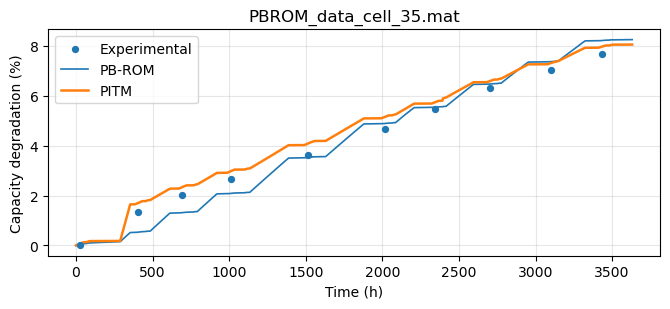

Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]

Saved → plots/PBROM_data_cell_35_pred_pct_BEST_RANDOM_SEARCH_MODEL.png

📊 PITM Testing Results (per cell)
  PBROM_data_cell_35.mat                [PITM] MSE=5.323e-09 RSEP=6.98% MAPE=10.44%    

Per-Cell Evaluation Complete.
Average RSEP: 6.9751%


In [16]:
# ==========================================================
# Cell 11 — Load Best Model from Random Search & Evaluate
# ==========================================================
import os
import tensorflow as tf
import numpy as np
import pandas as pd

RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Random search results not found at: {RESULTS_CSV}")

df_results = pd.read_csv(RESULTS_CSV)

# Sort by avg_rsep_pitm ascending (lower is better)
df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)
best_row = df_sorted.iloc[0]

print("🏆  Best model found from Random Search (Stage 2)")
print(best_row)

BEST_RUN_NUM   = int(best_row["run_num"])
BEST_WS        = int(best_row["window_size"])
BEST_LAYERS    = int(best_row["num_layers"])
BEST_EMBED     = int(best_row["embed_dim"])
BEST_LAMBDA_PHYS = float(best_row["lambda_phys"])

# Rebuild the model architecture with these hyperparameters
print(f"\nRebuilding best model from random search:")
print(f"  Run number:   {BEST_RUN_NUM}")
print(f"  Window Size:  {BEST_WS}")
print(f"  Num Layers:   {BEST_LAYERS}")
print(f"  Embed Dim:    {BEST_EMBED}")
print(f"  lambda_phys:  {BEST_LAMBDA_PHYS:.4f}")

tf.keras.backend.clear_session()

model = build_pitm_model(
    window_size=BEST_WS,
    num_groups=NUM_GROUPS,
    embed_dim=BEST_EMBED,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=BEST_LAYERS,
    dropout=DROPOUT
)

# Load the best checkpoint from that run
run_name = f"rs2_run{BEST_RUN_NUM}"
CHECKPOINT_NAME = f"{run_name}_best.h5"
MODEL_TO_TEST = os.path.join("checkpoints", CHECKPOINT_NAME)

if not os.path.exists(MODEL_TO_TEST):
    raise FileNotFoundError(f"Checkpoint not found: {MODEL_TO_TEST}")
else:
    model.load_weights(MODEL_TO_TEST)
    print(f"\n✅ Successfully loaded weights from: {MODEL_TO_TEST}")

# Run full evaluation on TEST cells with plots
print("\nRunning final evaluation on all TEST cells...")
results = evaluate_model_on_test(
    model,
    window_size=BEST_WS,
    stride=STRIDE,
    plot_suffix="BEST_RANDOM_SEARCH_MODEL",
    do_plot=True
)

rsep_values = [res[3] for res in results if np.isfinite(res[3])]
final_avg_rsep = np.mean(rsep_values) if rsep_values else np.nan

print("\n" + "="*50)
print(f"Per-Cell Evaluation Complete.")
print(f"Average RSEP: {final_avg_rsep:.4f}%")
print("="*50)


In [10]:
# ==========================================================
# Cell 12 — Export Best-Model Test Curves for This Battery Group
# ==========================================================
import os
import joblib
import numpy as np

# 🔧 1) Set a short label for THIS notebook's battery group
#     ➜ Change ONLY this string in your other scripts
BATTERY_GROUP_LABEL = "PBROM_Cells_2"   # <-- EDIT for each group script

# 🔧 2) Directory where we will save the export file
EXPORT_DIR = "export_curves"
os.makedirs(EXPORT_DIR, exist_ok=True)

# ----------------------------------------------------------
# Helper: collect the exact curves used in Cell 11's plots
# ----------------------------------------------------------
def collect_test_curves_for_export(model, window_size, stride):
    """
    For each TEST cell:
      - Run predict_cell(...)
      - Align model outputs to experimental timestamps
      - Build a dictionary with everything needed to re-plot:
            * t_exp_hours, Q_exp_pct   (scatter)
            * t_dense_hours, Q_pb_pct, Q_hat_pct  (lines)
    Returns:
      list of dicts, one per test cell
    """
    curves = []

    for fn in TEST_FILES:
        # This uses the same predict_cell that Cell 6a / 11 rely on
        out = predict_cell(model, fn, window_size, stride)
        if out is None or len(out) < 7:
            print(f"[Export] WARNING: predict_cell returned invalid output for {fn}")
            continue

        (t_dense, q_exp_norm_d, q_pb_norm_d,
         q_hat_norm_d, cap_nom, Time_s_full, t_exp) = out

        if t_dense.size == 0:
            print(f"[Export] WARNING: no windows for {fn}, skipping.")
            continue

        # --- Reproduce the same alignment as in evaluate_model_on_test ---
        ts_dense = t_dense
        # Restrict experimental timestamps to the model coverage
        t_exp_use = t_exp[(t_exp >= ts_dense[0]) & (t_exp <= ts_dense[-1])]
        if t_exp_use.size == 0:
            print(f"[Export] WARNING: no experimental times within model horizon for {fn}, skipping.")
            continue

        idx = nearest_indices(ts_dense, t_exp_use)
        if idx.size == 0:
            print(f"[Export] WARNING: nearest_indices returned empty for {fn}, skipping.")
            continue

        # Stamp experimental/Q curves at those timestamps
        Q_exp_norm_stamp   = q_exp_norm_d[idx]
        Q_pb_norm_stamp    = q_pb_norm_d[idx]
        Q_pred_norm_stamp  = q_hat_norm_d[idx]

        # Convert to plotting units (same as Cell 6a / 11):
        #   time in hours, degradation in %
        t_exp_hours   = t_exp_use / 3600.0
        t_dense_hours = t_dense / 3600.0

        Q_exp_pct = 100.0 * Q_exp_norm_stamp
        Q_pb_pct  = 100.0 * q_pb_norm_d
        Q_hat_pct = 100.0 * q_hat_norm_d

        curves.append({
            "file_name":   os.path.basename(fn),
            "t_exp_hours": t_exp_hours.astype(np.float64),
            "Q_exp_pct":   Q_exp_pct.astype(np.float64),
            "t_dense_hours": t_dense_hours.astype(np.float64),
            "Q_pb_pct":    Q_pb_pct.astype(np.float64),
            "Q_hat_pct":   Q_hat_pct.astype(np.float64),
            "Cap_Nom":     float(cap_nom),
        })

    return curves

# ----------------------------------------------------------
# 3) Collect curves + package everything into one object
# ----------------------------------------------------------
print("\n[Export] Collecting curves for best random-search model...")

# We assume Cell 11 has already defined:
#   - model           (best model loaded)
#   - BEST_WS         (best window size)
#   - STRIDE          (global stride)
#   - results         (per-cell metrics from evaluate_model_on_test)
curves = collect_test_curves_for_export(
    model,
    window_size=BEST_WS,
    stride=STRIDE
)

if not curves:
    print("[Export] No curves collected — nothing to save.")
else:
    export_payload = {
        "battery_group": BATTERY_GROUP_LABEL,
        "window_size":   BEST_WS,
        "stride":        STRIDE,
        "results_table": results,   # metrics from Cell 11 (MSE / RSEP / MAPE)
        "curves":        curves,    # list of dicts (per test cell)
    }

    # File name includes the group label so different scripts won't collide
    export_path = os.path.join(
        EXPORT_DIR,
        f"pitm_best_randomsearch_curves_{BATTERY_GROUP_LABEL}.joblib"
    )
    joblib.dump(export_payload, export_path)

    print(f"[Export] Saved best-model curves for group '{BATTERY_GROUP_LABEL}'")
    print(f"         → {export_path}")
    print(f"         Cells exported: {len(curves)}")



[Export] Collecting curves for best random-search model...
  (Testing PBROM_data_cell_35.mat: using 'PBROM_Cells_2' scaler, ID: 0)
[Export] Saved best-model curves for group 'PBROM_Cells_2'
         → export_curves/pitm_best_randomsearch_curves_PBROM_Cells_2.joblib
         Cells exported: 1


In [9]:
# ===============================================================
# Cell A — Data Extraction (Robust Loading)
# ===============================================================
import os
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

print("⚙️ Setting up for Analysis...")

# 1. Load Results CSV to find the True Best Model
csv_path = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Results file not found: {csv_path}")

df_results = pd.read_csv(csv_path)
# Sort by best metric (ascending RSEP)
df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)
best_row = df_sorted.iloc[0]

# 2. Extract EXACT Hyperparameters from the Best Run
#    (This prevents the Layer Mismatch error)
BEST_RUN_NUM = int(best_row["run_num"])
BEST_WS      = int(best_row["window_size"])
BEST_LAYERS  = int(best_row["num_layers"])
BEST_EMBED   = int(best_row["embed_dim"])

print(f"🏆 Loading Best Model (Run #{BEST_RUN_NUM})")
print(f"   Window Size: {BEST_WS}")
print(f"   Layers:      {BEST_LAYERS}")
print(f"   Embed Dim:   {BEST_EMBED}")

# 3. Rebuild Model with MATCHING Architecture
tf.keras.backend.clear_session()

# Ensure we use the global constants if they aren't in the CSV row
# (assuming NUM_GROUPS, NUM_HEADS, FF_DIM are constant across runs)
model = build_pitm_model(
    window_size=BEST_WS,
    num_groups=NUM_GROUPS,
    embed_dim=BEST_EMBED,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=BEST_LAYERS,
    dropout=0.0 # No dropout for inference
)

# 4. Load Weights
ckpt_path = os.path.join("checkpoints", f"rs2_run{BEST_RUN_NUM}_best.h5") 

if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
    print(f"✅ Loaded weights from {ckpt_path}")
else:
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

# 5. Extract Predictions
#    (Rest of the data extraction code remains the same)
all_exp_scaled, all_pb_scaled, all_pitm_scaled, all_soh = [], [], [], []
current_group = None
current_scaler = None

print("📊 Extracting predictions from Test Files...")
for fn in tqdm(TEST_FILES, ncols=80):
    # Load Data
    p = load_numpy_series(fn)
    
    # Load Group Scaler
    group_name = FILE_TO_GROUP_MAP[fn]
    if group_name != current_group:
        current_group = group_name
        current_scaler = joblib.load(os.path.join("scalers", f"delta_scaler_{group_name}.pkl"))
        group_id = GROUP_TO_ID_MAP[group_name]

    # Prepare Inputs
    rows6 = np.stack([p["SOC"], p["V_norm"], p["T_norm"], p["t_abs_norm"], p["dt_norm"], p["Cr"]], axis=1)
    rows7_ph = np.concatenate([rows6, np.zeros((rows6.shape[0], 1), np.float64)], axis=1)
    rows_scaled = feature_scaler.transform(rows7_ph).astype(np.float32)[:, :6]
    static_vec = static_scaler.transform(p["static"].reshape(1, -1)).astype(np.float32)
    win_pos = np.linspace(0, 1, BEST_WS, dtype=np.float32).reshape(-1, 1)
    
    # Create Batches (Stride 10 for efficiency)
    indices = range(BEST_WS, p["N"], 10)
    if len(indices) == 0: continue
    
    num = len(indices)
    b_dyn = np.zeros((num, BEST_WS, 7), dtype=np.float32)
    b_st = np.repeat(static_vec, num, axis=0)
    b_gid = np.full((num, 1), group_id, dtype=np.int32)
    
    b_exp, b_pb, b_cap = np.zeros(num), np.zeros(num), np.zeros(num)

    for idx, i in enumerate(indices):
        b_dyn[idx] = np.concatenate([rows_scaled[i-BEST_WS:i], win_pos], axis=1)
        # Targets (Last step)
        t_idx = i - 1
        # Scale targets using group scaler
        b_exp[idx] = current_scaler.transform([[p["dq_exp_scaled"][t_idx]]])[0][0]
        b_pb[idx]  = current_scaler.transform([[p["dq_pb_scaled"][t_idx]]])[0][0]
        b_cap[idx] = p["Q_exp_norm"][t_idx]

    # Predict
    preds = model.predict([b_dyn, b_st, b_gid], verbose=0).flatten()
    
    all_exp_scaled.extend(b_exp)
    all_pb_scaled.extend(b_pb)
    all_pitm_scaled.extend(preds)
    all_soh.extend(b_cap)

# Convert to Numpy
y_exp = np.array(all_exp_scaled)
y_pb  = np.array(all_pb_scaled)
y_pitm = np.array(all_pitm_scaled)
y_soh = np.array(all_soh)

print(f"✅ Data ready. Shape: {y_exp.shape}")

⚙️ Setting up for Analysis...
🏆 Loading Best Model (Run #16)
   Window Size: 10
   Layers:      5
   Embed Dim:   96
✅ Loaded weights from checkpoints/rs2_run16_best.h5
📊 Extracting predictions from Test Files...


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]

✅ Data ready. Shape: (6418,)


=== Physics-correction statistics (using filtered points) ===
N points used: 6362
Pearson r (x vs y): 0.9427   |   R^2: 0.8887
Spearman rho (x vs y): 0.6944
Best-fit: y = a x + b  with  a=0.9011,  b=1.4216e-01
Slope error (a-1): -0.0989
Mean |y-x| (scaled): 0.1887


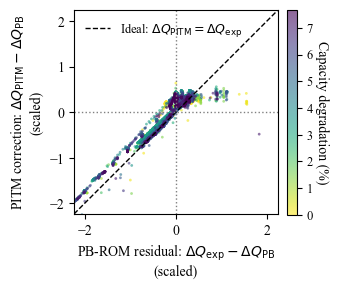

Saved Figure 1 to figs/fig_physics_correction_PITM_G2.png


In [16]:
# ===============================================================
# Cell B — Figure 1: Physics Correction Mechanism (NO "SOH")
#   + prints correlation numbers for paper
# ===============================================================
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import numpy as np

# 1) Register Fonts
font_dir = "fonts"  # Ensure this folder exists with .ttf files
for f in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
    fm.fontManager.addfont(f)

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
})

# 2) Calculate residuals
# X-axis: PB-ROM residual (experiment - physics)
physics_error = y_exp - y_pb
# Y-axis: PITM correction applied relative to PB-ROM
model_correction = y_pitm - y_pb

# 3) Filter extreme outliers (keep your threshold)
mask = (np.abs(physics_error) < 2.5) & (np.abs(model_correction) < 2.5)
x_clean = physics_error[mask].astype(float)
y_clean = model_correction[mask].astype(float)

# ---- Color variable: this is NOT SOH. It's your normalized experimental capacity loss.
capfade_raw = y_soh[mask].astype(float)  # came from p["Q_exp_norm"] in Cell A

# Convert to % if it looks like a fraction (e.g., 0.00–0.07)
if np.nanmax(capfade_raw) <= 1.5:
    c_clean = 100.0 * capfade_raw
    cbar_label = "Capacity degradation (%)"
else:
    c_clean = capfade_raw
    cbar_label = "Capacity degradation (scaled)"

# -----------------------------
# 3.5) NUMERIC “CORRELATION” INFO (for paper)
# -----------------------------
# Remove NaNs/Infs safely
valid = np.isfinite(x_clean) & np.isfinite(y_clean)
xv = x_clean[valid]
yv = y_clean[valid]

# Pearson correlation r (linear association)
r = np.corrcoef(xv, yv)[0, 1]
r2 = r**2

# Spearman correlation rho (rank-based; robust to nonlinearity)
# (no scipy dependency; uses rank via argsort twice, OK for large N)
def rankdata(a):
    a = np.asarray(a)
    order = np.argsort(a)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(len(a), dtype=float)
    return ranks

rho = np.corrcoef(rankdata(xv), rankdata(yv))[0, 1]

# Best-fit line y = a x + b (least squares)
a, b = np.polyfit(xv, yv, 1)

# How close is it to ideal y=x? report slope error + intercept
slope_err = a - 1.0

# Optional: mean absolute deviation from ideal line y=x
mad_to_ideal = np.mean(np.abs(yv - xv))

print("=== Physics-correction statistics (using filtered points) ===")
print(f"N points used: {len(xv)}")
print(f"Pearson r (x vs y): {r:.4f}   |   R^2: {r2:.4f}")
print(f"Spearman rho (x vs y): {rho:.4f}")
print(f"Best-fit: y = a x + b  with  a={a:.4f},  b={b:.4e}")
print(f"Slope error (a-1): {slope_err:.4f}")
print(f"Mean |y-x| (scaled): {mad_to_ideal:.4f}")

# 4) Plot
fig, ax = plt.subplots(figsize=(3.6, 3.6))

sc = ax.scatter(
    xv, yv,
    c=c_clean[valid],
    cmap="viridis_r",
    s=4,
    alpha=0.6,
    edgecolor="none",
    rasterized=True
)

# Symmetric limits + equal aspect (so y=x is visually correct)
lim = np.quantile(np.abs(np.concatenate([xv, yv])), 0.995)
lim = max(lim, 1e-6)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect("equal", adjustable="box")

# Reference lines
ax.plot([-lim, lim], [-lim, lim], "k--", linewidth=1.0,
        label=r"Ideal: $\Delta Q_{\mathrm{PITM}}=\Delta Q_{\mathrm{exp}}$")


ax.axhline(0, color="gray", linestyle=":", linewidth=1.0)
ax.axvline(0, color="gray", linestyle=":", linewidth=1.0)

# Labels
# ax.set_xlabel(r"PB-ROM residual: $\Delta Q_{\mathrm{exp}}-\Delta Q_{\mathrm{PB}}$ (scaled)")
# ax.set_ylabel(r"PITM correction: $\Delta Q_{\mathrm{PITM}}-\Delta Q_{\mathrm{PB}}$ (scaled)")
# Labels (put "(scaled)" on 2nd line)
ax.set_xlabel(r"PB-ROM residual: $\Delta Q_{\mathrm{exp}}-\Delta Q_{\mathrm{PB}}$" + "\n" + r"(scaled)")
ax.set_ylabel(r"PITM correction: $\Delta Q_{\mathrm{PITM}}-\Delta Q_{\mathrm{PB}}$" + "\n" + r"(scaled)")



ax.legend(frameon=False, loc="upper left")

# Colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(cbar_label, rotation=270, labelpad=12)
cbar.ax.tick_params(labelsize=9)

# Save
plt.tight_layout()
out_path = "figs/fig_physics_correction_PITM_G2.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()
print(f"Saved Figure 1 to {out_path}")
